# hetan: ridge regression on macro variables and a basket of related stocks is what i’d suggest

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pandas_datareader as pdr
import quantstats as qs
import pytz

import datetime as dt

from sklearn import linear_model

In [3]:
snp_data = pd.read_csv('../Data/Structured_Data/snp500.csv')
snp = pd.Series(snp_data[['Symbol']].squeeze()).tolist()

In [4]:
pd.__version__

'1.4.3'

# Try Hetan's suggestion - rough generalization of pairs trading on multiple assets

In [5]:
# tickerName: string, a single ticker
# period can be '_mo', '_
def downloadClosingPrices(tickerName, period='6mo'):
    return yf.Ticker(tickerName).history(period=period)[['Close']]

# closingPrices: a Pandas Dataframe of closing prices
# returns a list of returns
def getReturns(closingPrices):
    return closingPrices.pct_change(1).dropna() #closingPrices.diff().reset_index(drop=True)[1:].reset_index(drop=True).div(closingPrices[:-1].reset_index(drop=True))

# tickerNames: a list of strings of ticker names
# returns a dictionary of ticker names to lists of their daily returns
def makeDailyReturnsDf(tickerNames, period='6mo'):
    ticker_data = {}
  
    longestIndex = pd.Series(dtype='float64')
    # retrieve data
    for t in tickerNames:
        # take over the past 6 months
        c = downloadClosingPrices(t, period)
        # store longest index
        if len(c.index) >= len(longestIndex):
            longestIndex = c.index[1:]
        # No data found, symbol may be delisted
        if len(c) == 0:
            continue
        else:
            ticker_data[t] = getReturns(c).rename(columns={"Close":t}).squeeze().tolist()
    # remove stocks which are not of the same length
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    # ticker_data
    return pd.DataFrame(ticker_data, index = longestIndex)

# tickersToPredict DOESN'T have to be a subset of tickers
# returns a dictionary with the name of the stock as keys and the LM predicting that stock as values
# trains pair-wise LMs using same-day returns of related stocks as predictors
def trainLM(tickers, tickerToPredict):

    X = makeDailyReturnsDf(tickers)
    y = makeDailyReturnsDf([tickerToPredict])

    lm = Ridge()
    if tickerToPredict in X.columns:
        X.drop(columns=tickerToPredict, inplace=True)
    lm.fit(X, y)
    print(tickerToPredict, lm.score(X, y))
    return lm

In [6]:
# TODO: change to return series?
## zscore fn to generate buy/sell signals on a daily basis
# takes the zscore of a particular day's prediction over a window of past days
# lm: the linear model predicting stock returns based on related stocks
# X: a dataframe of predictors - returns of stocks related to the target
# y: a list of the target stock's returns
# days: number of days back to scale over
def zscore(lm, X, y, days=30):
    # lookback = min(len(X), len(y), days)
    lookback = days
    # print('lookback',lookback)
    steps = len(X)
    z_ts = []
    for s in range(steps,lookback,-1):
        X_window, y_window = X.iloc[s-lookback:s,], y.iloc[s-lookback:s]
        # predict for the last lookback no. of days
        y_hats = lm.predict(X_window)
        # get the residuals
        y_res = y_window - y_hats

        # get residual for today
        y_res_t = y_res.iloc[-1]
        y_res_ex_t = y_res.iloc[:-1]

        scaler = StandardScaler()
        # fit scale based on residuals up to yesterday
        scaler.fit(np.asarray(y_res_ex_t).reshape(-1,1))

        # transform today's residual
        z_t = scaler.transform(np.asarray(y_res_t).reshape(-1,1))
        z_ts.append(z_t[0][0])
    return z_ts

## Make Rolling Regression model (without sentiment)

In [7]:
spy = makeDailyReturnsDf(["SPY"], '4y')
spy

SPY
Date                               
2018-11-09 00:00:00-05:00 -0.009768
2018-11-12 00:00:00-05:00 -0.018685
2018-11-13 00:00:00-05:00 -0.001871
2018-11-14 00:00:00-05:00 -0.006837
2018-11-15 00:00:00-05:00  0.010436
...                             ...
2022-11-01 00:00:00-04:00 -0.004376
2022-11-02 00:00:00-04:00 -0.025096
2022-11-03 00:00:00-04:00 -0.010297
2022-11-04 00:00:00-04:00  0.014393
2022-11-07 00:00:00-05:00  0.009566

[1005 rows x 1 columns]

In [8]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def Model(tickers_to_predict, tickers_as_predictors, window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        Xhist = makeDailyReturnsDf([t for t in tickers_as_predictors if t != tick], '4y')
        yhist = makeDailyReturnsDf([tick],'4y')
        Xyhist = pd.concat([Xhist, yhist], axis=1)
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()

    retsSpreads['Date'] = retsSpreads['Date'].dt.tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

# Compile lists of relevant stocks

In [9]:
snp_data[:10]

Symbol                      Description      Category2  Category3  \
0   AAPL                        Apple Inc  Common stocks  Large cap   
1   MSFT                   Microsoft Corp  Common stocks  Large cap   
2   GOOG             Alphabet Inc Class C  Common stocks  Large cap   
3  GOOGL             Alphabet Inc Class A  Common stocks  Large cap   
4   AMZN                  Amazon.Com Inc.  Common stocks  Large cap   
5   TSLA                        Tesla Inc  Common stocks  Large cap   
6  BRK.B  Berkshire Hathaway Inc. Class B  Common stocks  Large cap   
7    UNH           Unitedhealth Group Inc  Common stocks  Large cap   
8    XOM                 Exxon Mobil Corp  Common stocks  Large cap   
9    JNJ                Johnson & Johnson  Common stocks  Large cap   

              GICS Sector          Market cap Dividend yield  \
0  Information Technology  $2,396,557,976,700          0.60%   
1  Information Technology  $1,700,887,137,266          1.08%   
2  Communication Services  $1,091,160,310,000          0.00%   
3  Communication Services  $1,091,160,310,000          0.00%   
4  Consumer Discretionary    $987,418,107,695          0.00%   
5  Consumer Discretionary    $713,867,145,652          0.00%   
6              Financials    $648,469,030,904          0.00%   
7             Health Care    $511,944,311,010          1.13%   
8                  Energy    $466,400,177,773          3.10%   
9             Health Care    $452,540,967,536          2.51%   

   Price to TTM earnings  Price to TTM sales  Price to book value   Action  
0                  21.67                6.21                32.78  Analyze  
1                  22.04                8.83                 9.80  Analyze  
2                   6.82                4.04                 2.00  Analyze  
3                   6.69                4.04                 1.96  Analyze  
4                  42.54                2.07                 6.80  Analyze  
5                  80.33               11.48                19.79  Analyze  
6                   4.42                1.83                 0.71  Analyze  
7                  29.14                1.73                 6.99  Analyze  
8                  17.95                1.52                 2.74  Analyze  
9                  22.51                4.77                 5.97  Analyze

Some of the top tech stocks like Google are classified as "Communication Services", so we include those

In [10]:
top20_it_stocks = snp_data[snp_data['GICS Sector'] == 'Information Technology']['Symbol'].to_list()[:20]
top20_stocks = snp_data['Symbol'].to_list()[:20]
top20_comm_stocks = snp_data[snp_data['GICS Sector']=='Communication Services']['Symbol'].to_list()[:20]
top20_it_comm_stocks = snp_data[snp_data['GICS Sector'].isin(['Information Technology', 'Communication Services'])]['Symbol'].to_list()[:20]

In [11]:
top20_it_comm_stocks

['AAPL',
 'MSFT',
 'GOOG',
 'GOOGL',
 'V',
 'NVDA',
 'MA',
 'META',
 'ORCL',
 'DIS',
 'AVGO',
 'TMUS',
 'ACN',
 'CSCO',
 'CRM',
 'VZ',
 'TXN',
 'ADBE',
 'CMCSA',
 'QCOM']

100%|██████████| 1/1 [00:10<00:00, 10.67s/it]

ols.rsquared Date
2018-11-09 00:00:00-05:00    NaN
2018-11-12 00:00:00-05:00    NaN
2018-11-13 00:00:00-05:00    NaN
2018-11-14 00:00:00-05:00    NaN
2018-11-15 00:00:00-05:00    NaN
                            ... 
2022-11-01 00:00:00-04:00    1.0
2022-11-02 00:00:00-04:00    1.0
2022-11-03 00:00:00-04:00    1.0
2022-11-04 00:00:00-04:00    1.0
2022-11-07 00:00:00-05:00    1.0
Length: 1005, dtype: float64


                           Strategy
-------------------------  ----------
Start Period               2019-05-06
End Period                 2022-11-07
Risk-Free Rate             2.0%
Time in Market             100.0%

Cumulative Return          164.2%
CAGR﹪                     31.89%

Sharpe                     0.91
Prob. Sharpe Ratio         88.83%
Smart Sharpe               0.78
Sortino                    1.33
Smart Sortino              1.14
Sortino/√2                 0.94
Smart Sortino/√2           0.8
Omega                      1.18

Max Drawdown               -31.43%
Longest DD Days            307
Volatility (ann.)          34.78%
Calmar                     1.01
Skew                       -0.03
Kurtosis                   4.45

Expected Daily %           0.11%
Expected Monthly %         2.29%
Expected Yearly %          27.49%
Kelly Criterion            8.29%
Risk of Ruin               0.0%
Daily Value-at-Risk        -3.47%
Expected Shortfall (cVaR)  -3.47%

Max Consecutive Wins     

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2020-02-13  2020-03-23  2020-06-05   113    -31.426154        -29.937769
2  2022-01-04  2022-06-16  2022-11-07   307    -27.210086        -26.370598
3  2020-09-02  2020-09-18  2020-12-28   117    -20.375479        -20.166803
4  2021-01-27  2021-03-08  2021-07-07   161    -18.598451        -16.066058
5  2019-05-07  2019-06-03  2019-07-23    77    -16.554035        -15.701797

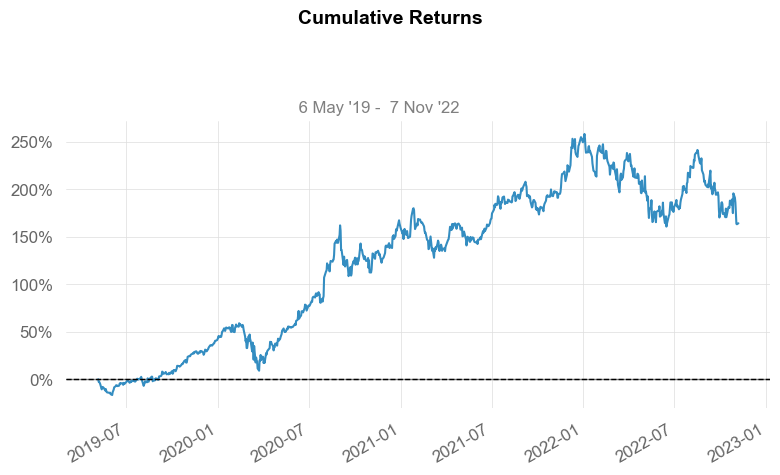

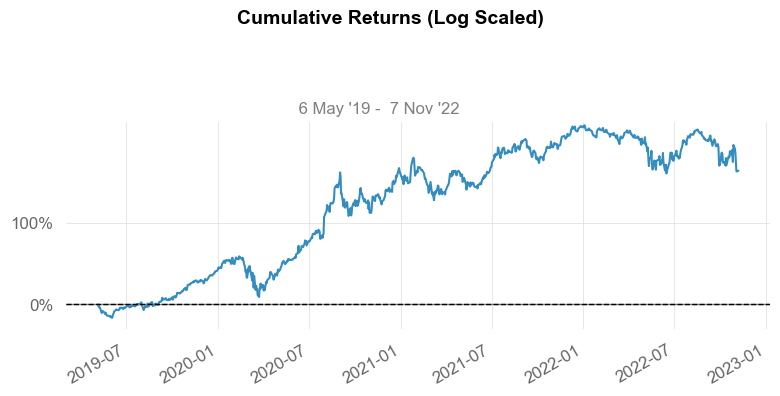

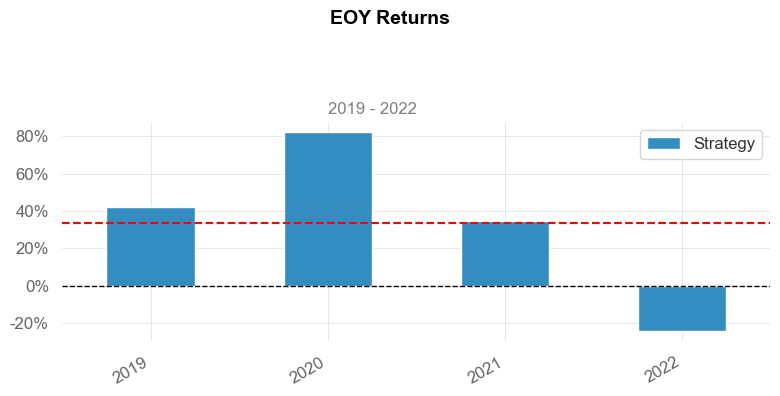

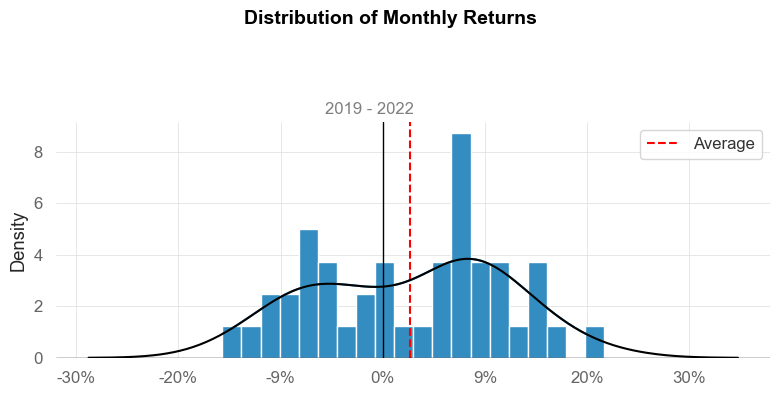

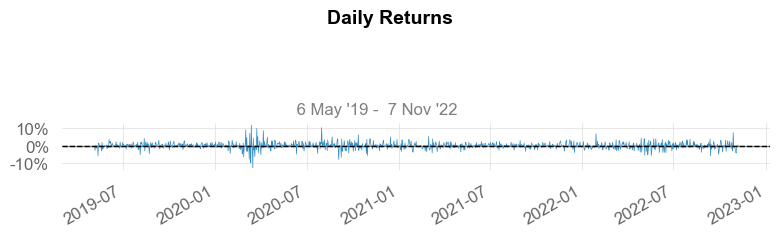

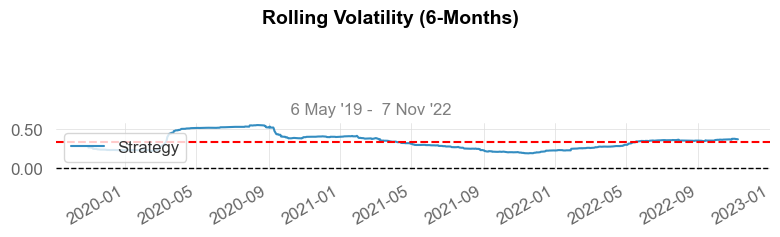

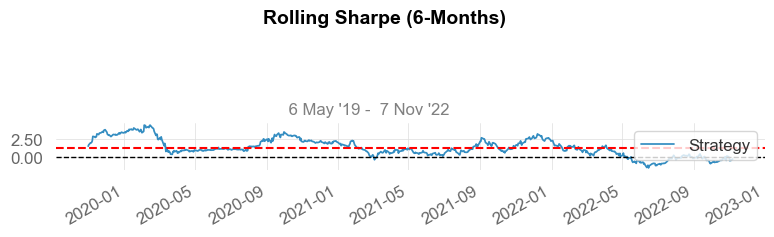

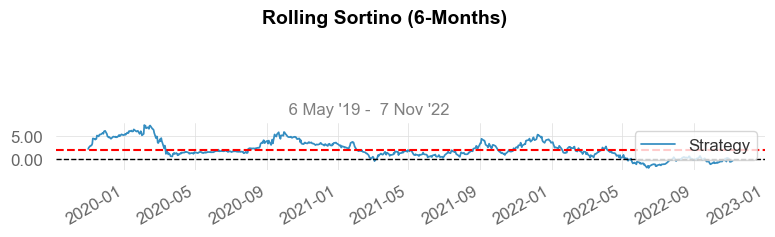

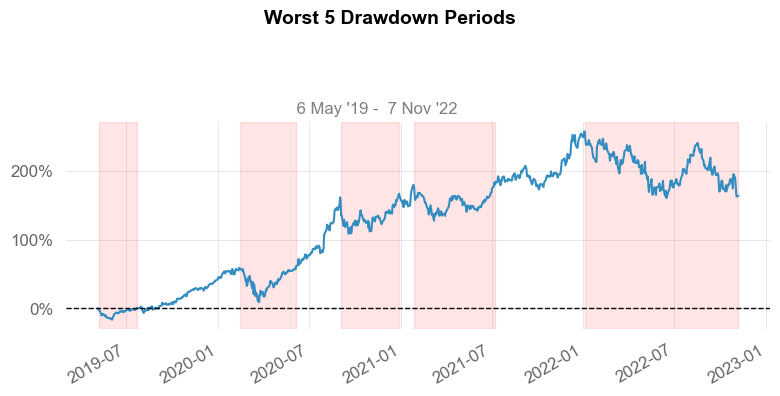

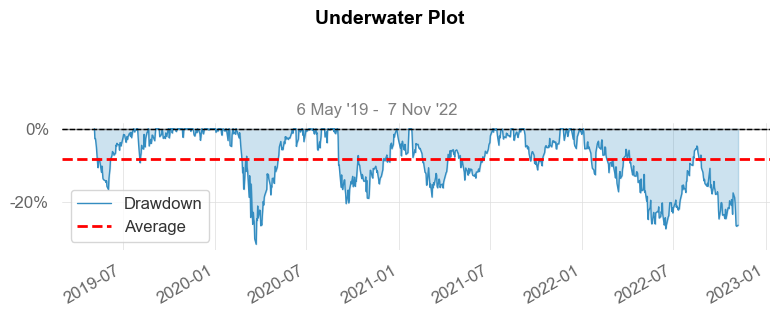

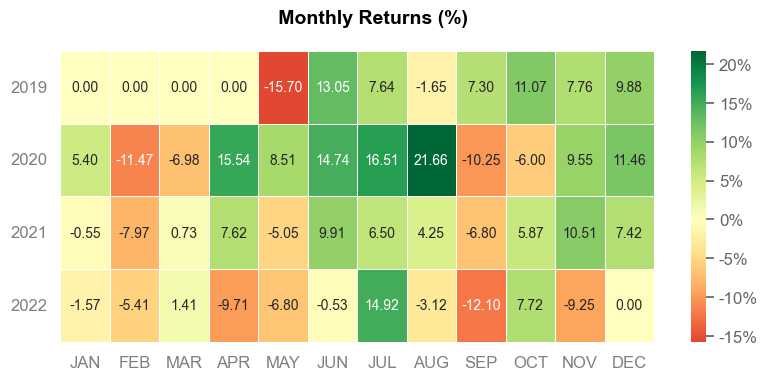

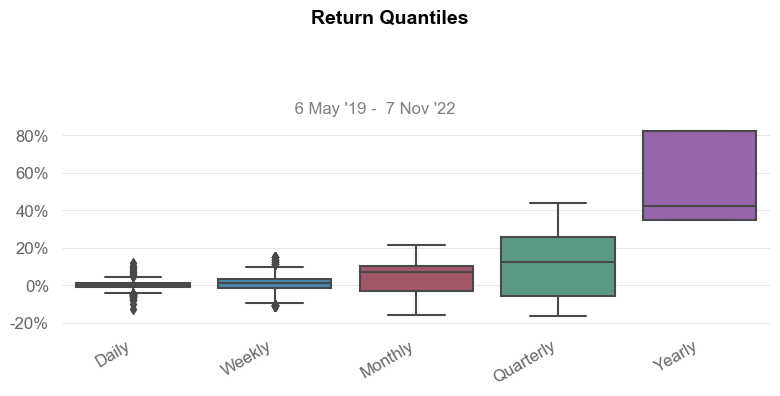

In [12]:
Model(['AAPl'], top20_it_comm_stocks)

# Try Model with incorporation of sentiment

cache returns data into csvs so that we don't get the newest data from dynamic calls to yahoo finance. This allows us to match the dates with those from the predictions from the sentiment analyses techniques which are also not dynamic and stored in csvs.

In [13]:
# top20_it_stocks_df = makeDailyReturnsDf(top20_it_stocks, '1y')
# top20_it_stocks_df.to_csv('../Data/Structured_Data/top20_it_stocks.csv')
# top20_it_comm_stocks_df = makeDailyReturnsDf(top20_it_comm_stocks, '1y')
# top20_it_comm_stocks_df.to_csv('../Data/Structured_Data/top20_it_comm_stocks.csv')

In [14]:
# AAPL = makeDailyReturnsDf(['AAPL'], '1y')
# AAPL.to_csv('../Data/Structured_Data/AAPL.csv')
# TSLA = makeDailyReturnsDf(['TSLA'], '1y')
# TSLA.to_csv('../Data/Structured_Data/TSLA.csv')
# META = makeDailyReturnsDf(['META'], '1y')
# META.to_csv('../Data/Structured_Data/META.csv')

In [15]:
def readDailyReturnsFromCsv(tickerNames, period='6mo', filepath='../Data/Structured_Data/'):
    ticker_data = {}
    longestIndex = pd.Series(dtype='float64')
    for t in tickerNames:
        df = pd.read_csv(filepath+t+'.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
        df.index = pd.to_datetime(df.index, utc=True).date
        df.index.rename('Date', inplace=True)
        ticker_data[t] = df
        if df.shape[0] >= len(longestIndex):
            longestIndex = df.index[1:]
    lens = [len(v) for v in ticker_data.values()]
    longest = max(lens)
    ticker_data_copy = ticker_data.copy()
    for k, v in ticker_data_copy.items():
        if len(v) < longest:
            ticker_data.pop(k)
    combined = pd.concat(list(ticker_data.values()))
    return combined
    

In [16]:
combined = readDailyReturnsFromCsv(['TSLA'])
combined.drop(columns=['TSLA'], inplace=True)
combined

Empty DataFrame
Columns: []
Index: [2021-11-09, 2021-11-10, 2021-11-11, 2021-11-12, 2021-11-15, 2021-11-16, 2021-11-17, 2021-11-18, 2021-11-19, 2021-11-22, 2021-11-23, 2021-11-24, 2021-11-26, 2021-11-29, 2021-11-30, 2021-12-01, 2021-12-02, 2021-12-03, 2021-12-06, 2021-12-07, 2021-12-08, 2021-12-09, 2021-12-10, 2021-12-13, 2021-12-14, 2021-12-15, 2021-12-16, 2021-12-17, 2021-12-20, 2021-12-21, 2021-12-22, 2021-12-23, 2021-12-27, 2021-12-28, 2021-12-29, 2021-12-30, 2021-12-31, 2022-01-03, 2022-01-04, 2022-01-05, 2022-01-06, 2022-01-07, 2022-01-10, 2022-01-11, 2022-01-12, 2022-01-13, 2022-01-14, 2022-01-18, 2022-01-19, 2022-01-20, 2022-01-21, 2022-01-24, 2022-01-25, 2022-01-26, 2022-01-27, 2022-01-28, 2022-01-31, 2022-02-01, 2022-02-02, 2022-02-03, 2022-02-04, 2022-02-07, 2022-02-08, 2022-02-09, 2022-02-10, 2022-02-11, 2022-02-14, 2022-02-15, 2022-02-16, 2022-02-17, 2022-02-18, 2022-02-22, 2022-02-23, 2022-02-24, 2022-02-25, 2022-02-28, 2022-03-01, 2022-03-02, 2022-03-03, 2022-03-04, 2022-03-07, 2022-03-08, 2022-03-09, 2022-03-10, 2022-03-11, 2022-03-14, 2022-03-15, 2022-03-16, 2022-03-17, 2022-03-18, 2022-03-21, 2022-03-22, 2022-03-23, 2022-03-24, 2022-03-25, 2022-03-28, 2022-03-29, 2022-03-30, 2022-03-31, 2022-04-01, ...]

[251 rows x 0 columns]

In [17]:
readDailyReturnsFromCsv(['TSLA',])

TSLA
Date                
2021-11-09 -0.119903
2021-11-10  0.043429
2021-11-11 -0.004158
2021-11-12 -0.028293
2021-11-15 -0.019382
...              ...
2022-11-01  0.001231
2022-11-02 -0.056360
2022-11-03  0.001535
2022-11-04 -0.036413
2022-11-07 -0.050080

[251 rows x 1 columns]

In [23]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def ModelwSentiment(tickers_to_predict=['AAPL'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', sentiment_file = '/finbert_pred_returns_rfr_test.csv', 
        window = 120, lookback = 30, thresh = 1, rets = True, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        #TODO: read from csv file instead of pulling live data to match the sentiment predictions by Elton
        yhist = readDailyReturnsFromCsv([tick])
        yhist.index = pd.to_datetime(yhist.index, utc=True).date
        yhist.index.rename('Date', inplace=True)


        # returns data
        Xhist_rets = readDailyReturnsFromCsv(tickers_as_predictors)
        if tick in Xhist_rets.columns:
            Xhist_rets.drop(columns=tick, inplace=True)
        Xhist_rets.index = pd.to_datetime(Xhist_rets.index, utc=True).date
        Xhist_rets.index.rename('Date', inplace=True)

        # sentiment data
        Xhist_sent = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0)[tickers_to_predict]
        Xhist_sent.index = pd.to_datetime(Xhist_sent.index, utc=True).date
        Xhist_sent.index.rename('Date', inplace=True)

        # merge only on the dates that overlap
        Xhist = Xhist_rets.merge(Xhist_sent, how='inner', left_index=True, right_index=True, suffixes=('_rets','_sent'))
        yhist = yhist.loc[Xhist.index,:]

        Xyhist = pd.concat([Xhist, yhist], axis=1)
        # get betas
        if rets:
            if intercept:
                ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
            else:
                #TODO: add sentiment here
                ols = RollingOLS(yhist, Xhist, window=window).fit()
            betas = ols.params.dropna()
        else:
            if intercept:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            sm.add_constant(logPriceFromRets(Xhist)), window=window).fit()
            else:
                ols = RollingOLS(logPriceFromRets(yhist), 
                            logPriceFromRets(Xhist), window=window).fit()
            betas = ols.params.dropna()
        # get weights
        if intercept:
            if rets:
                spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * sm.add_constant(logPriceFromRets(Xhist))).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            if rets:
                #TODO: add sentiment here
                # spread is the residuals
                spread = yhist[tick] - (betas * (Xhist)).sum(1)
            else:
                spread = logPriceFromRets(yhist[tick]) - (betas * logPriceFromRets(Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        # drop predicted sentiment data as tradeable stock
        if tick in betas.columns:
            betas.drop(columns=tick, inplace=True)
        if tick in weights.columns:
            weights.drop(columns=tick, inplace=True)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()
    print(retsSpreads)

    retsSpreads['Date'] = pd.DatetimeIndex(retsSpreads['Date']).tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    print(qs.stats.sharpe(retsSpreads.mean(1), rf=0.02))
    # qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

In [24]:
ModelwSentiment(tickers_to_predict=['META'], sentiment_file='/stacked_pred_returns_rfr_test.csv')

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/705588631.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.730800
2022-08-26    0.723504
2022-08-29    0.724522
2022-08-30    0.722624
2022-08-31    0.711852
Length: 172, dtype: float64
          Date         0
0   2022-06-16  0.000000
1   2022-06-17 -0.001681
2   2022-06-21  0.003307
3   2022-06-22 -0.000593
4   2022-06-23 -0.001276
5   2022-06-24  0.011456
6   2022-06-27 -0.002490
7   2022-06-28 -0.001331
8   2022-06-29 -0.002060
9   2022-06-30 -0.003793
10  2022-07-01 -0.001829
11  2022-07-05  0.002901
12  2022-07-06  0.001278
13  2022-07-07  0.005628
14  2022-07-08 -0.000121
15  2022-07-11 -0.002500
16  2022-07-12 -0.003615
17  2022-07-13 -0.002542
18  2022-07-14  0.000167
19  2022-07-15  0.004135
20  2022-07-18  0.000615
21  2022-07-19  0.006639
22  2022-07-20  0.004878
23  2022-07-21  0.005470
24  2022-07-22 -0.007652
25  2022-07-25 -0.002558
26  2022-07-26 -0.005478
2

1.3452998398033476


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/4268203410.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:02<00:00,  2.78s/it]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.722723
2022-08-26    0.710241
2022-08-29    0.708974
2022-08-30    0.708207
2022-08-31    0.708241
Length: 172, dtype: float64


100%|██████████| 1/1 [00:02<00:00,  2.80s/it]


          Date         0
0   2022-06-16  0.000000
1   2022-06-17  0.001377
2   2022-06-21  0.000475
3   2022-06-22  0.000736
4   2022-06-23  0.002423
5   2022-06-24  0.002769
6   2022-06-27  0.000333
7   2022-06-28 -0.004850
8   2022-06-29 -0.001551
9   2022-06-30 -0.003386
10  2022-07-01  0.000271
11  2022-07-05  0.004068
12  2022-07-06  0.001502
13  2022-07-07  0.005962
14  2022-07-08  0.000824
15  2022-07-11 -0.006022
16  2022-07-12  0.000980
17  2022-07-13 -0.000162
18  2022-07-14  0.002540
19  2022-07-15  0.001764
20  2022-07-18 -0.001322
21  2022-07-19  0.004803
22  2022-07-20  0.005264
23  2022-07-21  0.003182
24  2022-07-22 -0.002162
25  2022-07-25 -0.001329
26  2022-07-26 -0.001145
27  2022-07-27  0.005081
28  2022-07-28 -0.003421
29  2022-07-29  0.003850
30  2022-08-01 -0.001181
31  2022-08-02 -0.000194
32  2022-08-03  0.006307
33  2022-08-04  0.002103
34  2022-08-05 -0.000572
35  2022-08-08 -0.002190
36  2022-08-09 -0.001058
37  2022-08-10  0.006009
38  2022-08-11 -0.000008


                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          2.41%
CAGR﹪                     12.13%

Sharpe                     1.83
Prob. Sharpe Ratio         80.06%
Smart Sharpe               1.71
Sortino                    2.78
Smart Sortino              2.59
Sortino/√2                 1.97
Smart Sortino/√2           1.83
Omega                      1.35

Max Drawdown               -1.45%
Longest DD Days            15
Volatility (ann.)          5.18%
Calmar                     8.39
Skew                       -0.32
Kurtosis                   0.28

Expected Daily %           0.04%
Expected Monthly %         0.8%
Expected Yearly %          2.41%
Kelly Criterion            16.44%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.49%
Expected Shortfall (cVaR)  -0.49%

Max Consecutive Wins       6
M

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-08-16  2022-08-26  2022-08-31    15     -1.446182         -1.441078
2  2022-06-28  2022-06-30  2022-07-07     9     -0.975846         -0.949040
3  2022-07-11  2022-07-11  2022-07-19     8     -0.602224         -0.520872
4  2022-07-22  2022-07-26  2022-07-27     5     -0.462902         -0.348794
5  2022-08-05  2022-08-09  2022-08-10     5     -0.381542         -0.276052

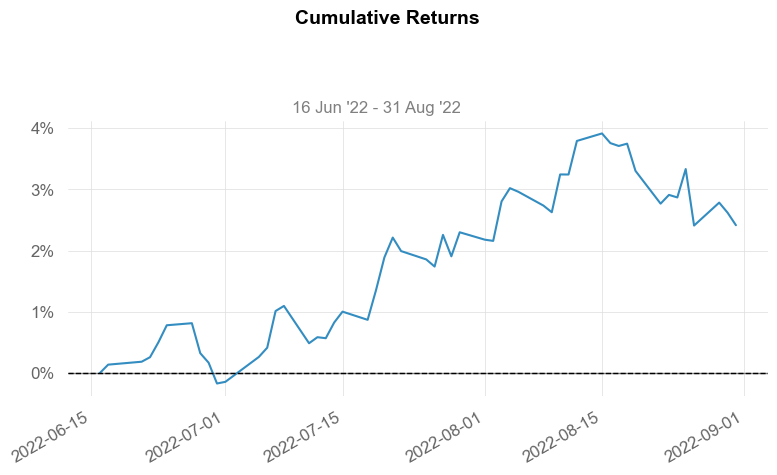

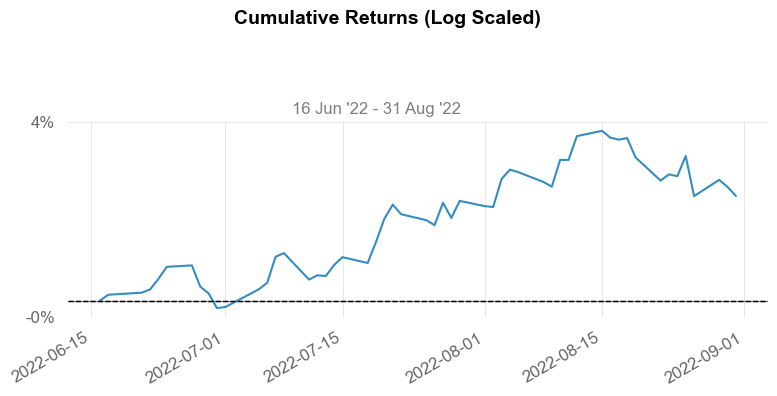

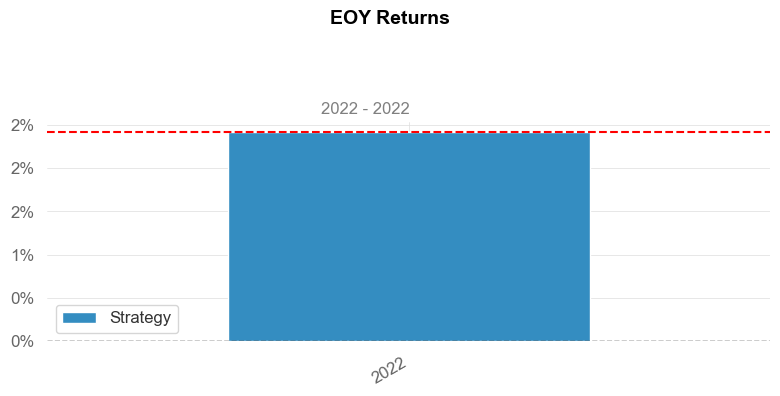

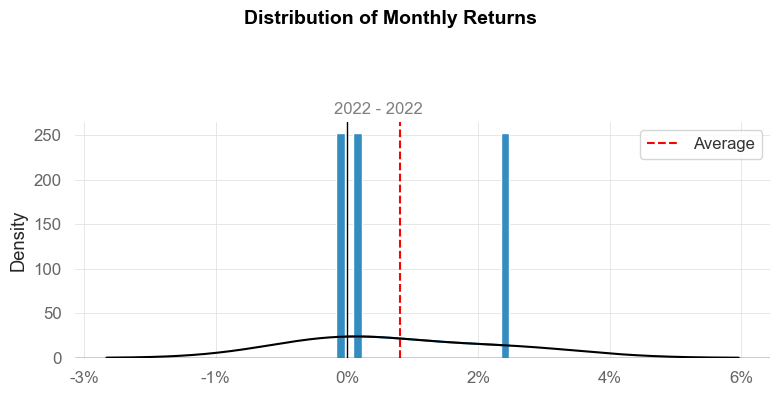

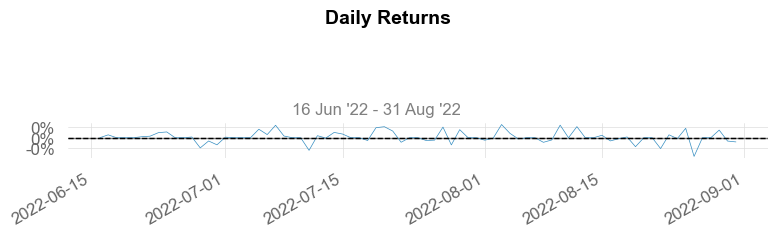

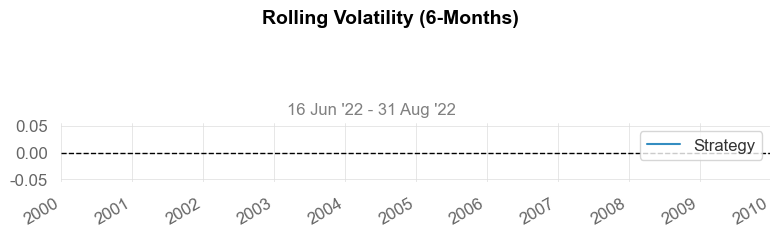

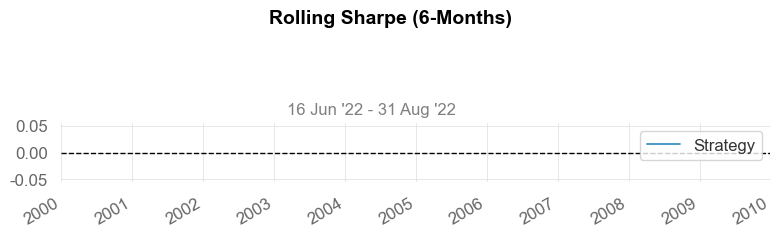

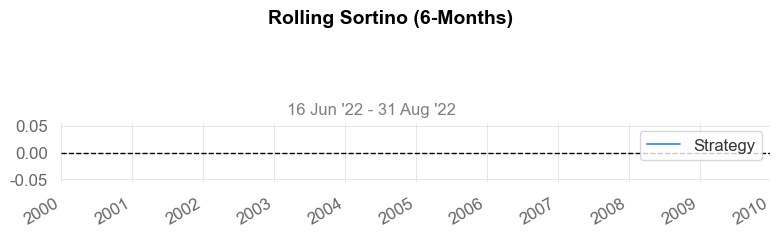

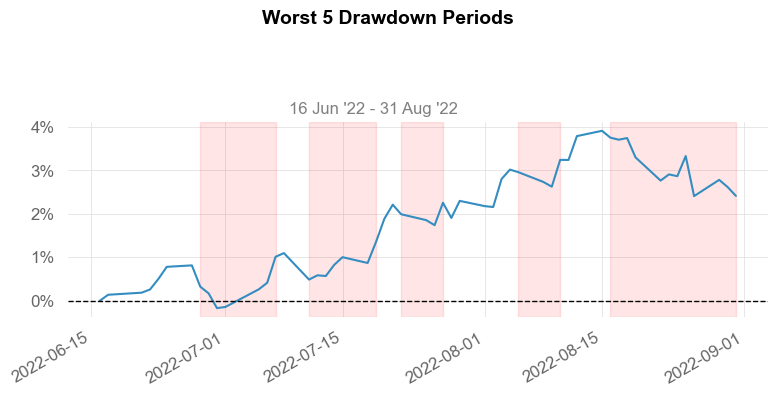

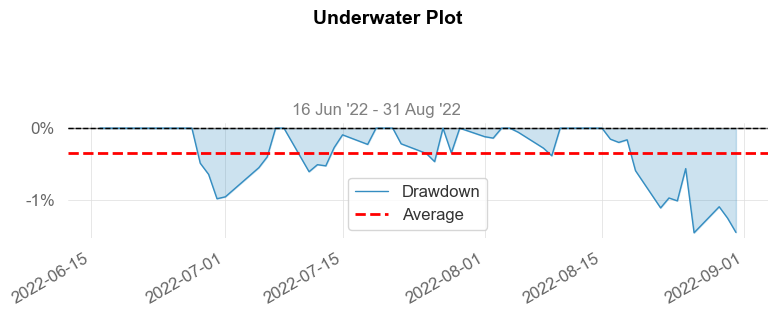

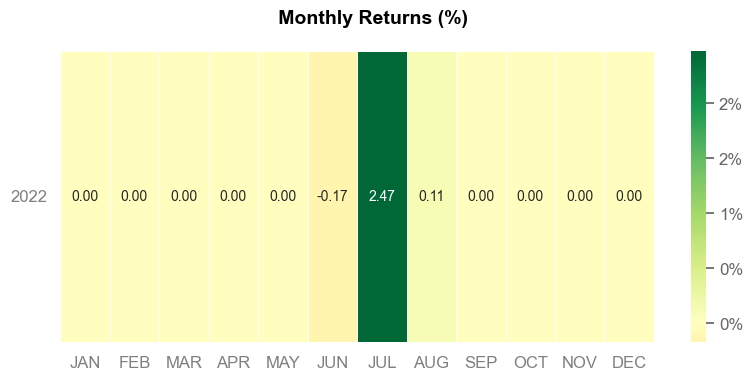

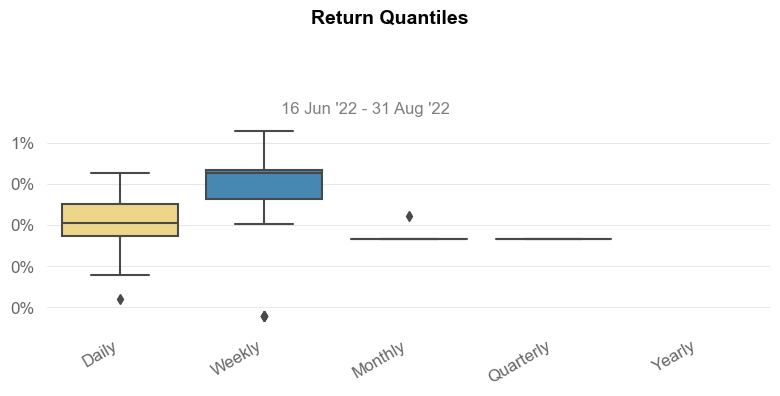

In [21]:
ModelwSentiment(tickers_to_predict=['TSLA'], sentiment_file='/stacked_pred_returns_rfr_test.csv')

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/4268203410.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:02<00:00,  2.96s/it]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.834164
2022-08-26    0.843520
2022-08-29    0.843467
2022-08-30    0.840931
2022-08-31    0.844452
Length: 172, dtype: float64
          Date         0
0   2022-06-16  0.000000
1   2022-06-17  0.001710
2   2022-06-21  0.008556
3   2022-06-22 -0.001257
4   2022-06-23  0.002038
5   2022-06-24  0.009062
6   2022-06-27 -0.003118
7   2022-06-28 -0.005267
8   2022-06-29 -0.000276
9   2022-06-30 -0.004267
10  2022-07-01  0.001475
11  2022-07-05  0.002196
12  2022-07-06  0.001993
13  2022-07-07  0.004808
14  2022-07-08 -0.000865
15  2022-07-11 -0.003323
16  2022-07-12 -0.004163
17  2022-07-13  0.001388
18  2022-07-14 -0.000076
19  2022-07-15  0.005360
20  2022-07-18 -0.003637
21  2022-07-19  0.010543
22  2022-07-20  0.001603
23  2022-07-21  0.001162
24  2022-07-22 -0.010979
25  2022-07-25 -0.000587
26  2022-07-26 -0.005467
2

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          0.92%
CAGR﹪                     4.49%

Sharpe                     0.36
Prob. Sharpe Ratio         55.84%
Smart Sharpe               0.36
Sortino                    0.55
Smart Sortino              0.55
Sortino/√2                 0.39
Smart Sortino/√2           0.39
Omega                      1.06

Max Drawdown               -2.88%
Longest DD Days            22
Volatility (ann.)          7.19%
Calmar                     1.56
Skew                       0.23
Kurtosis                   0.49

Expected Daily %           0.02%
Expected Monthly %         0.31%
Expected Yearly %          0.92%
Kelly Criterion            4.92%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.73%
Expected Shortfall (cVaR)  -0.73%

Max Consecutive Wins       4
Max

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-08-16  2022-08-31  2022-08-31    15     -2.878560         -2.688659
2  2022-07-22  2022-07-26  2022-08-01    10     -1.696386         -1.156006
3  2022-06-27  2022-06-30  2022-07-19    22     -1.287241         -1.141676
4  2022-08-05  2022-08-09  2022-08-10     5     -0.423477         -0.268623
5  2022-08-02  2022-08-02  2022-08-03     1     -0.355574          0.000000

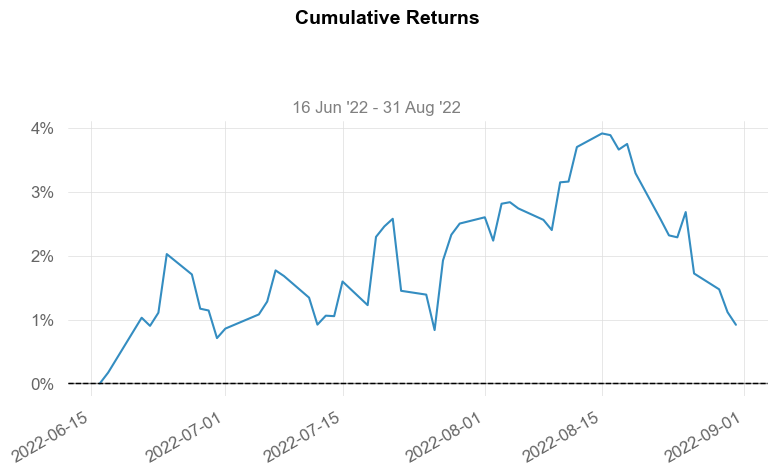

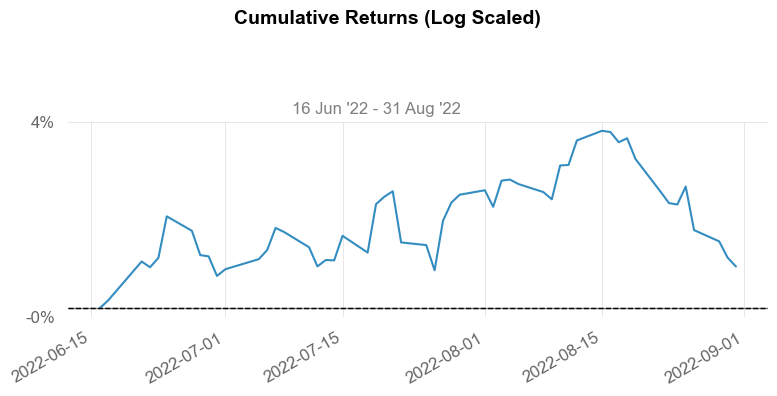

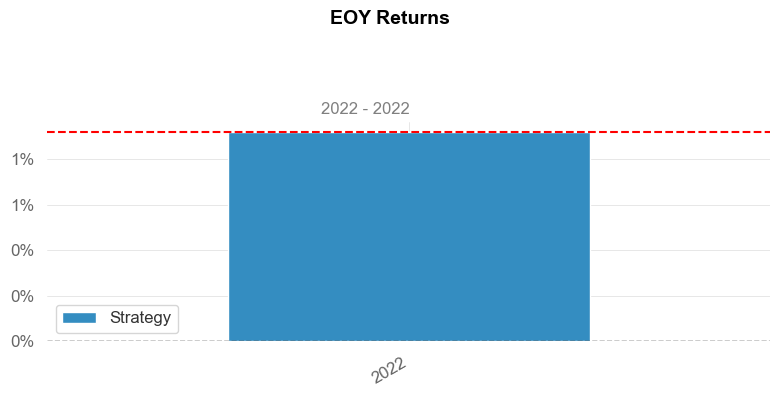

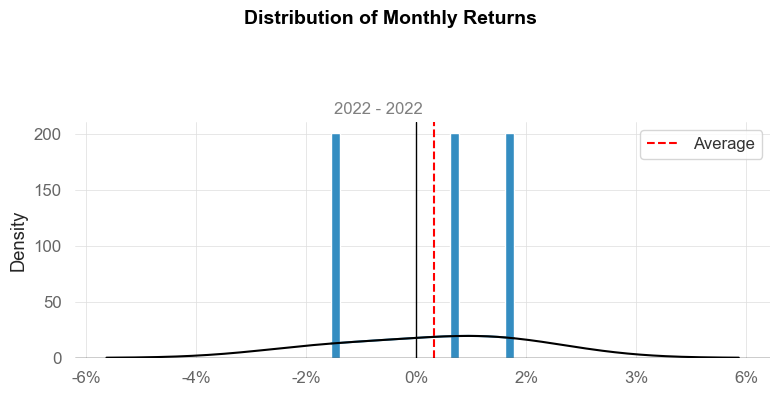

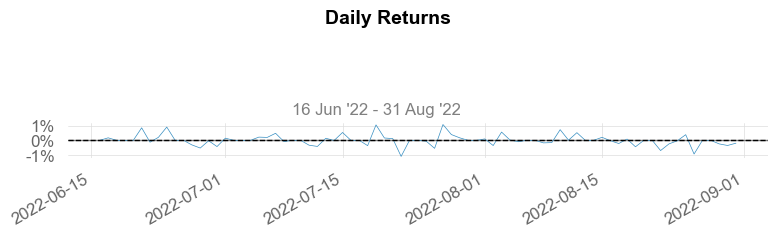

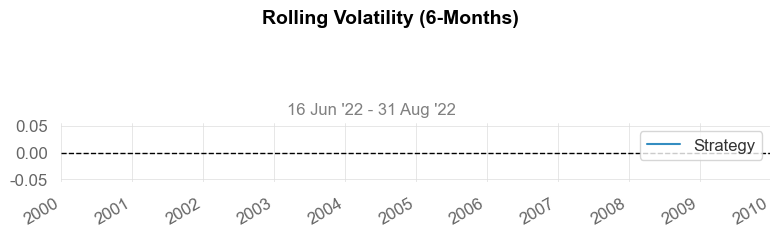

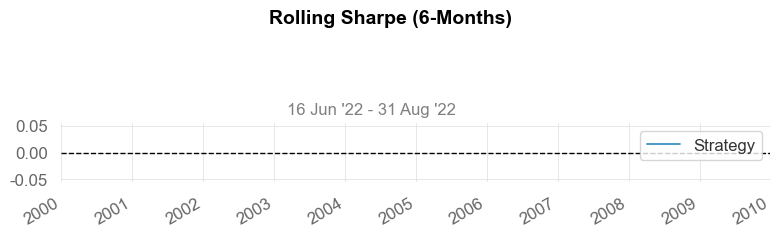

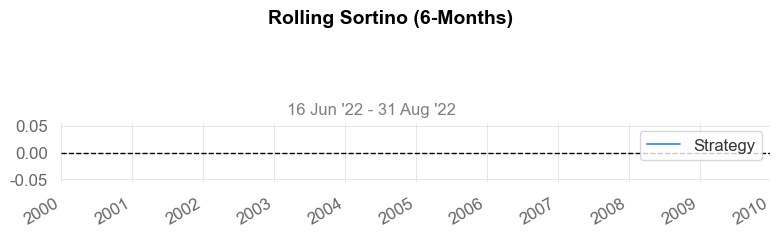

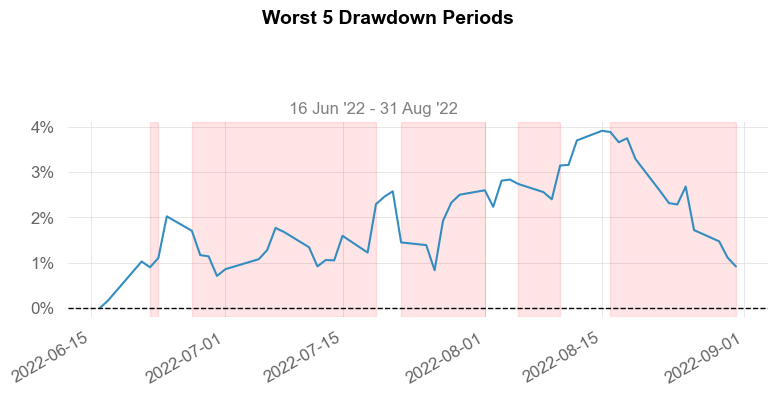

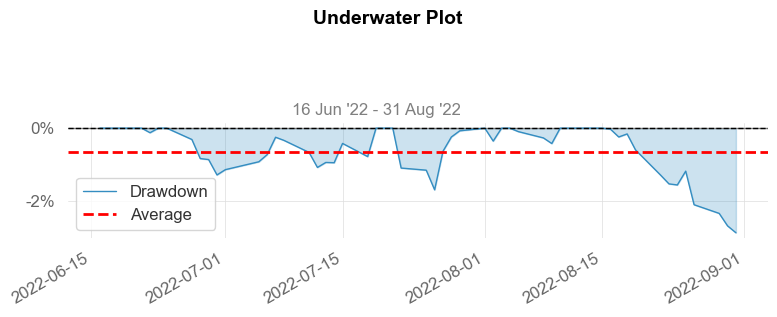

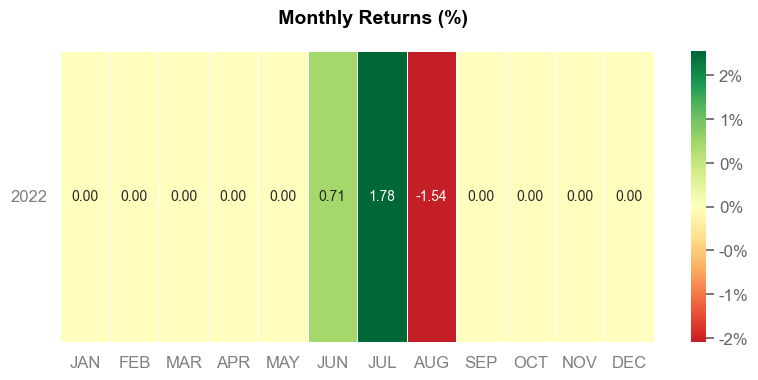

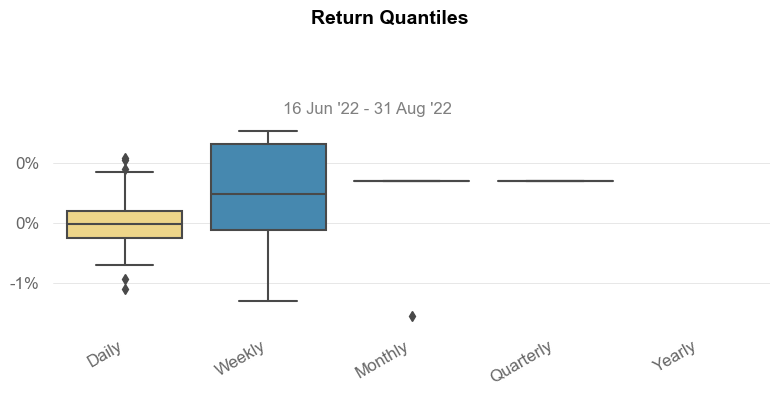

In [20]:
ModelwSentiment(tickers_to_predict=['AAPL'], sentiment_file='/stacked_pred_returns_rfr_test.csv')

predict the average of 3 stocks

  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1295/4268203410.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.73it/s]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.731313
2022-08-26    0.719370
2022-08-29    0.717462
2022-08-30    0.716348
2022-08-31    0.716082
Length: 172, dtype: float64


/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1295/4268203410.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.733564
2022-08-26    0.726322
2022-08-29    0.727322
2022-08-30    0.725264
2022-08-31    0.715572
Length: 172, dtype: float64
          Date         0         1
0   2022-06-16  0.000000  0.000000
1   2022-06-17  0.001585 -0.001504
2   2022-06-21  0.000570  0.003051
3   2022-06-22  0.000444 -0.000408
4   2022-06-23  0.002446 -0.000793
5   2022-06-24  0.003434  0.009674
6   2022-06-27  0.000291 -0.002102
7   2022-06-28 -0.004727 -0.001586
8   2022-06-29 -0.001528 -0.001478
9   2022-06-30 -0.003303 -0.003576
10  2022-07-01  0.000056 -0.001360
11  2022-07-05  0.004394  0.002871
12  2022-07-06  0.001312  0.000851
13  2022-07-07  0.007904  0.004542
14  2022-07-08  0.000300 -0.000256
15  2022-07-11 -0.006483 -0.001751
16  2022-07-12  0.001722 -0.002863
17  2022-07-13  0.000599 -0.002240
18  2022-07-14  0.002329  0.000561
1

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          2.3%
CAGR﹪                     11.53%

Sharpe                     1.77
Prob. Sharpe Ratio         79.87%
Smart Sharpe               1.69
Sortino                    2.83
Smart Sortino              2.71
Sortino/√2                 2.0
Smart Sortino/√2           1.91
Omega                      1.34

Max Drawdown               -1.53%
Longest DD Days            15
Volatility (ann.)          5.06%
Calmar                     7.54
Skew                       -0.01
Kurtosis                   -0.0

Expected Daily %           0.04%
Expected Monthly %         0.76%
Expected Yearly %          2.3%
Kelly Criterion            16.25%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.48%
Expected Shortfall (cVaR)  -0.48%

Max Consecutive Wins       5
Max

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-08-16  2022-08-26  2022-08-31    15     -1.528228         -1.497237
2  2022-06-27  2022-07-01  2022-07-07    10     -0.962186         -0.897616
3  2022-07-22  2022-07-26  2022-08-03    12     -0.946666         -0.643790
4  2022-07-11  2022-07-13  2022-07-19     8     -0.550157         -0.468489
5  2022-08-05  2022-08-09  2022-08-10     5     -0.429673         -0.206932

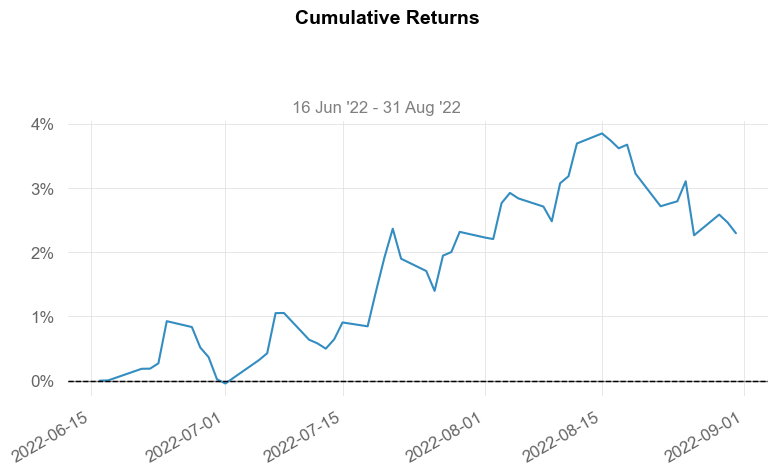

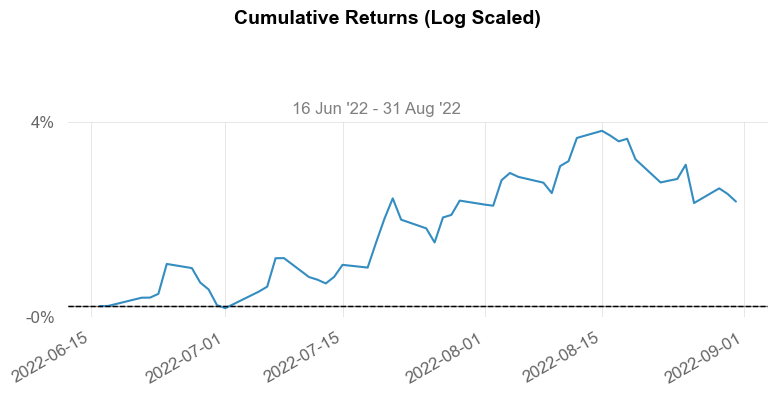

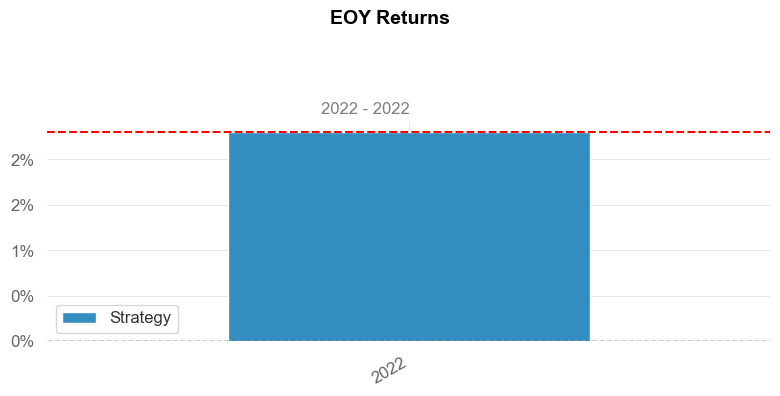

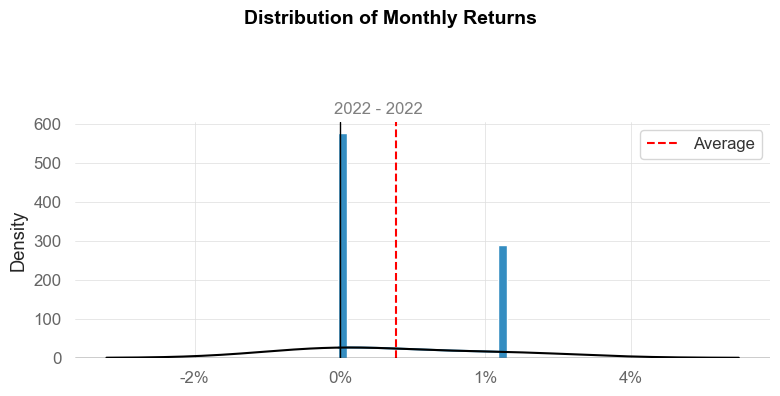

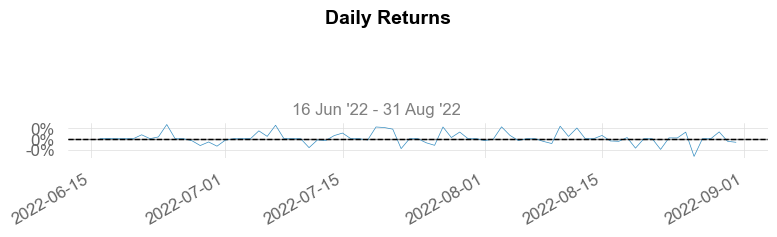

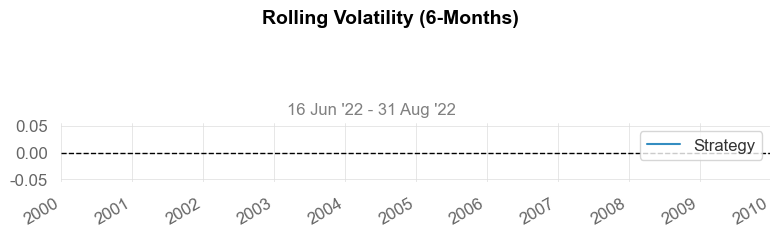

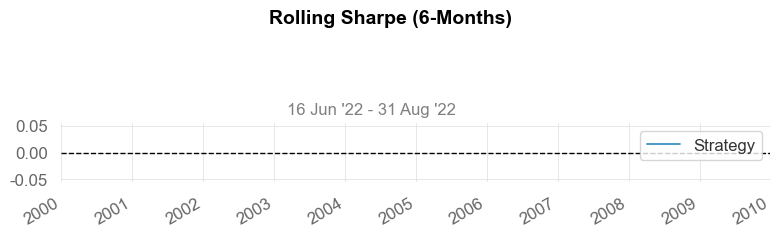

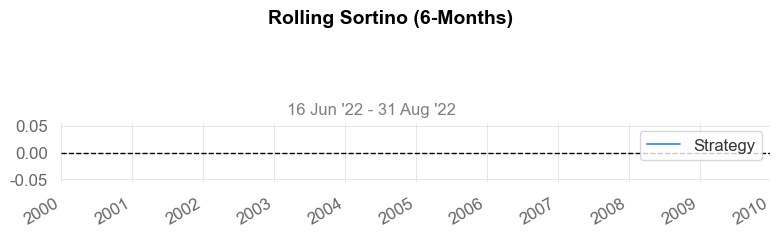

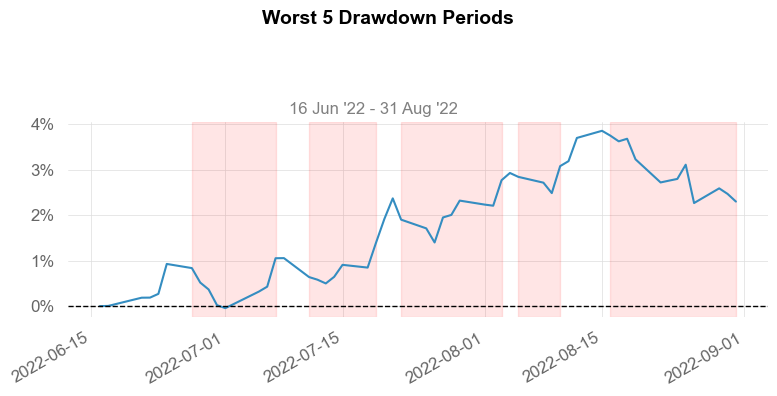

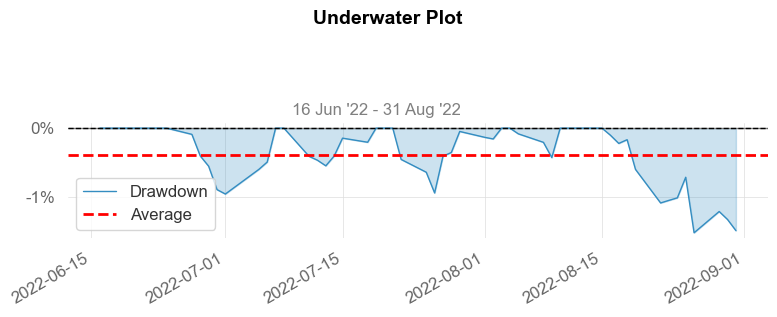

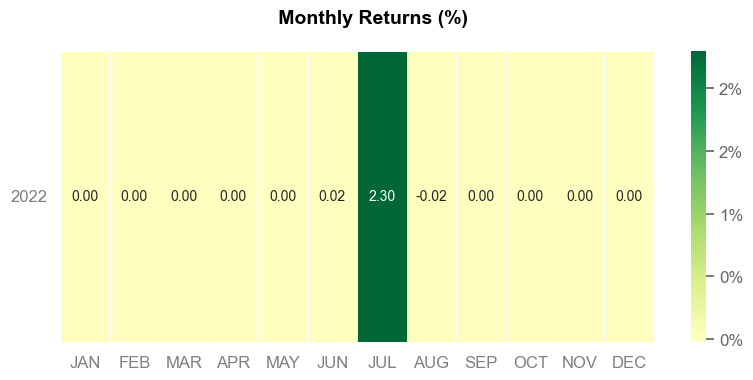

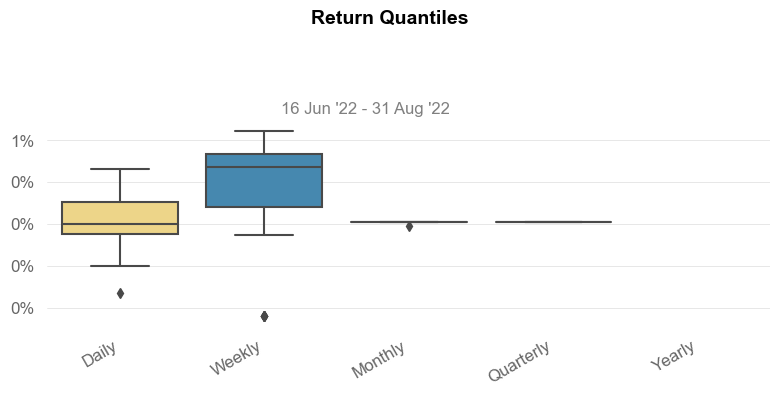

In [26]:
ModelwSentiment(tickers_to_predict=['AAPL', 'TSLA', 'META'])

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1295/3930470958.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tickers_to_predict, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

ols.rsquared Date
2021-12-27         NaN
2021-12-28         NaN
2021-12-29         NaN
2021-12-30         NaN
2021-12-31         NaN
                ...   
2022-08-25    0.833660
2022-08-26    0.843686
2022-08-29    0.843779
2022-08-30    0.841206
2022-08-31    0.844212
Length: 172, dtype: float64
          Date         0
0   2022-06-16  0.000000
1   2022-06-17  0.001713
2   2022-06-21  0.008690
3   2022-06-22 -0.001298
4   2022-06-23  0.001920
5   2022-06-24  0.009065
6   2022-06-27 -0.003219
7   2022-06-28 -0.005395
8   2022-06-29 -0.000179
9   2022-06-30 -0.004247
10  2022-07-01  0.001498
11  2022-07-05  0.001940
12  2022-07-06  0.002058
13  2022-07-07  0.004882
14  2022-07-08 -0.000914
15  2022-07-11 -0.003280
16  2022-07-12 -0.004285
17  2022-07-13 -0.001555
18  2022-07-14 -0.000148
19  2022-07-15  0.005396
20  2022-07-18 -0.003835
21  2022-07-19  0.010655
22  2022-07-20  0.001535
23  2022-07-21  0.001163
24  2022-07-22 -0.010927
25  2022-07-25 -0.000594
26  2022-07-26 -0.005506
2

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          0.71%
CAGR﹪                     3.44%

Sharpe                     0.22
Prob. Sharpe Ratio         53.33%
Smart Sharpe               0.22
Sortino                    0.34
Smart Sortino              0.34
Sortino/√2                 0.24
Smart Sortino/√2           0.24
Omega                      1.04

Max Drawdown               -2.79%
Longest DD Days            23
Volatility (ann.)          7.19%
Calmar                     1.23
Skew                       0.31
Kurtosis                   0.54

Expected Daily %           0.01%
Expected Monthly %         0.23%
Expected Yearly %          0.71%
Kelly Criterion            3.74%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.73%
Expected Shortfall (cVaR)  -0.73%

Max Consecutive Wins       4
Max

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-08-16  2022-08-31  2022-08-31    15     -2.792545         -2.606079
2  2022-07-22  2022-07-26  2022-08-01    10     -1.695768         -1.151528
3  2022-06-27  2022-06-30  2022-07-20    23     -1.298351         -1.282189
4  2022-08-05  2022-08-09  2022-08-10     5     -0.410662         -0.260892
5  2022-08-02  2022-08-02  2022-08-03     1     -0.347287          0.000000

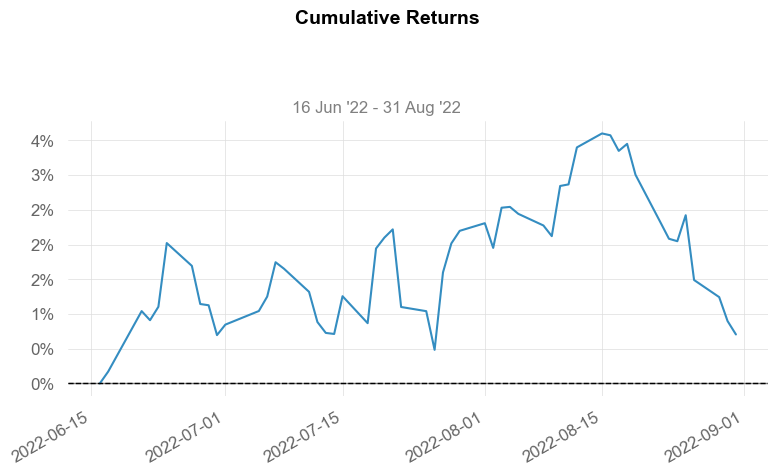

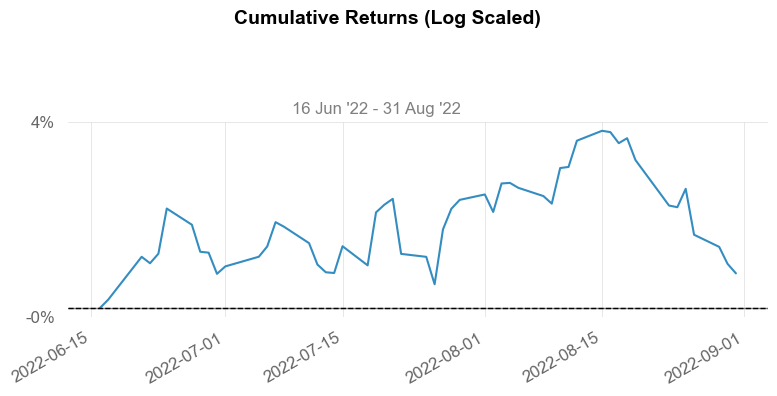

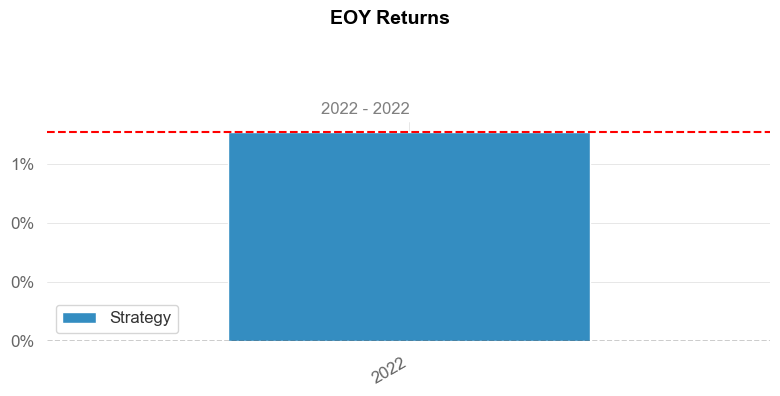

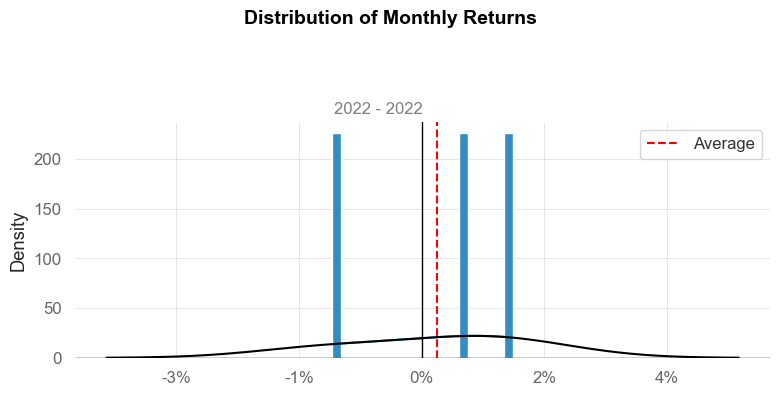

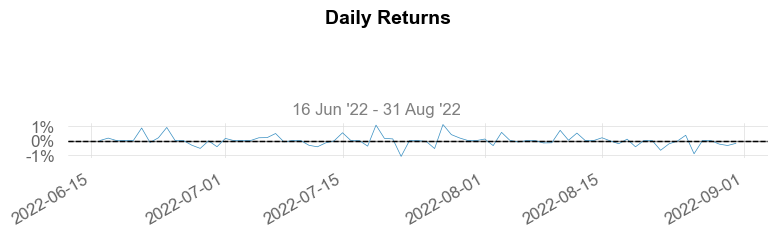

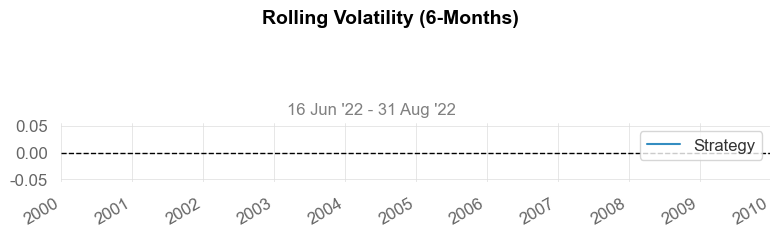

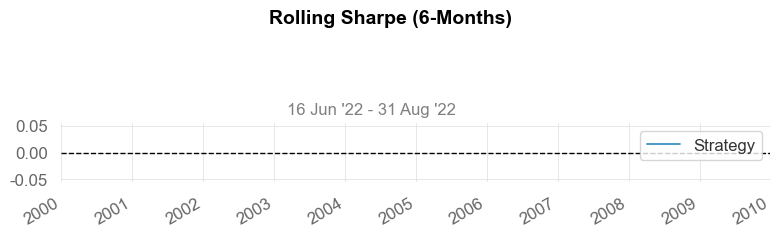

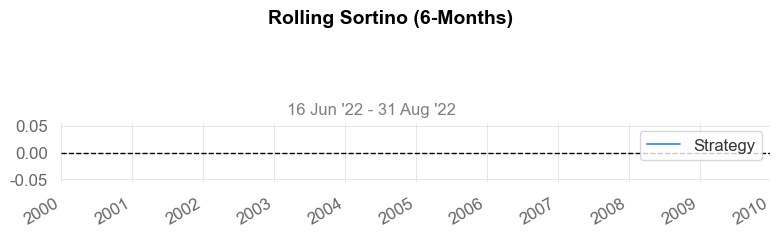

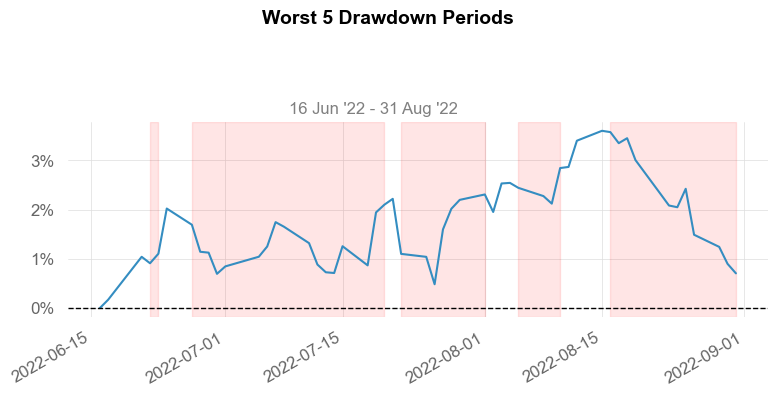

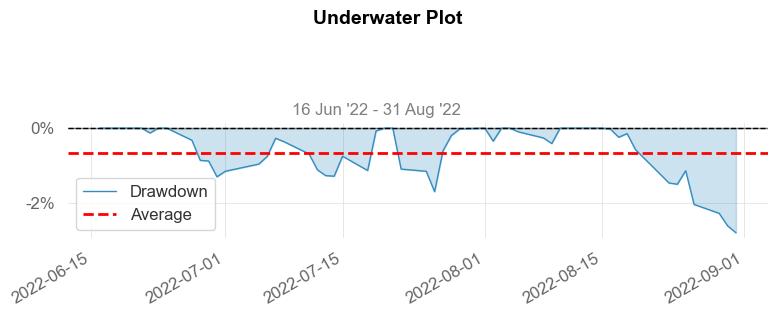

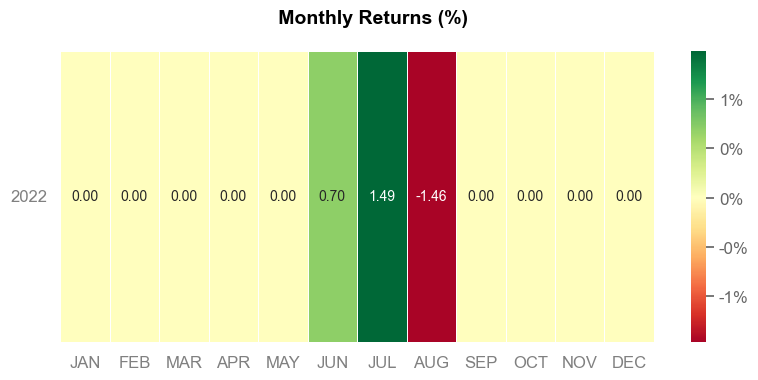

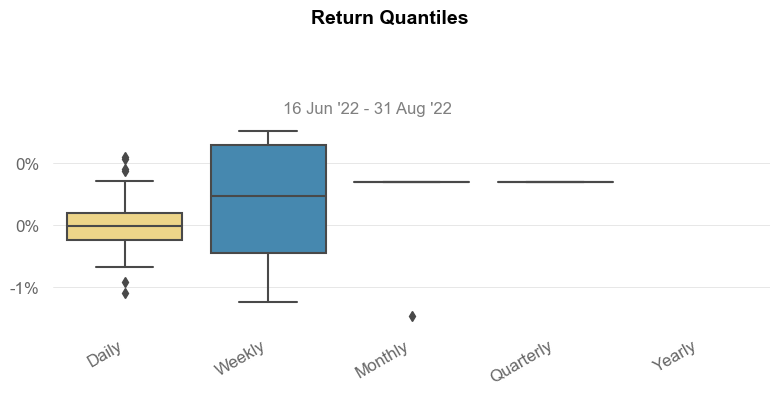

In [20]:
ModelwSentiment()

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1118/2588586244.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tickers_to_predict, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.29it/s]

Xhist_rets
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM'],
      dtype='object')
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM'],
      dtype='object')
initial weights
Index(['TSLA', 'AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META',
       'ORCL', 'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN',
       'ADBE', 'CMCSA', 'QCOM', 'TSLA'],
      dtype='object')
betas.columns
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM', 'TSLA'],
      dtype='object')
betas.columns after dropping
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'META', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM',

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          2.54%
CAGR﹪                     12.83%

Sharpe                     2.02
Prob. Sharpe Ratio         82.49%
Smart Sharpe               1.89
Sortino                    3.1
Smart Sortino              2.89
Sortino/√2                 2.19
Smart Sortino/√2           2.04
Omega                      1.39

Max Drawdown               -1.37%
Longest DD Days            15
Volatility (ann.)          4.99%
Calmar                     9.39
Skew                       -0.31
Kurtosis                   0.17

Expected Daily %           0.05%
Expected Monthly %         0.84%
Expected Yearly %          2.54%
Kelly Criterion            17.57%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.47%
Expected Shortfall (cVaR)  -0.47%

Max Consecutive Wins       6
M

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-08-16  2022-08-31  2022-08-31    15     -1.365523         -1.357951
2  2022-06-28  2022-06-30  2022-07-07     9     -0.923811         -0.878987
3  2022-07-11  2022-07-11  2022-07-19     8     -0.572075         -0.488123
4  2022-07-22  2022-07-26  2022-07-27     5     -0.428110         -0.319433
5  2022-08-05  2022-08-09  2022-08-10     5     -0.372925         -0.266999

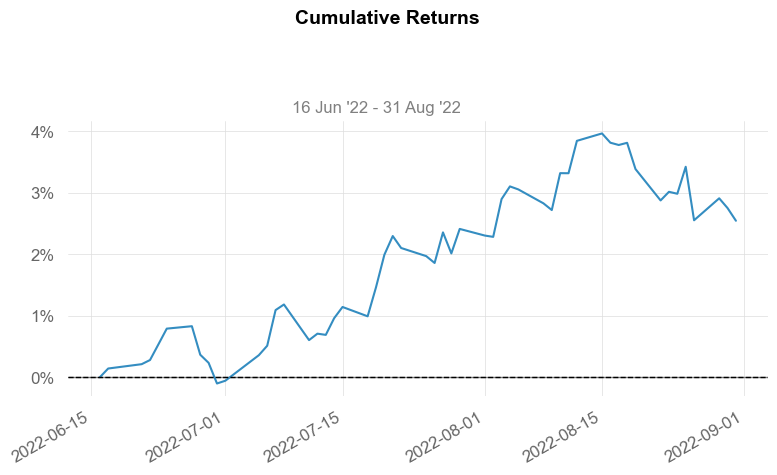

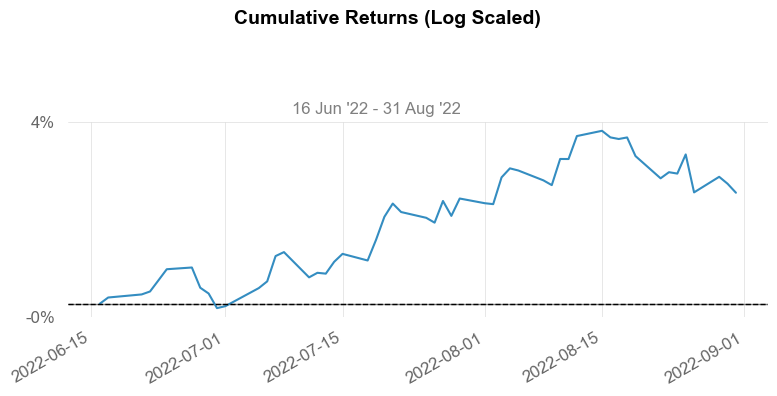

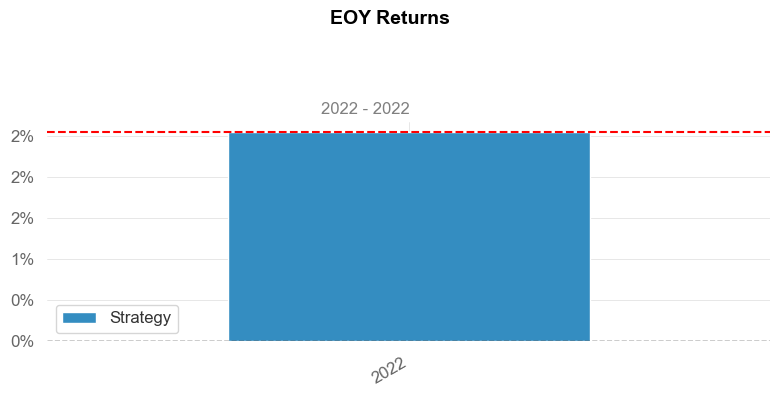

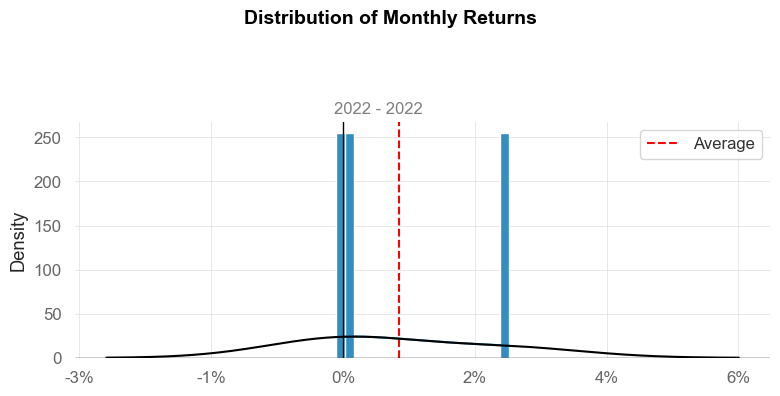

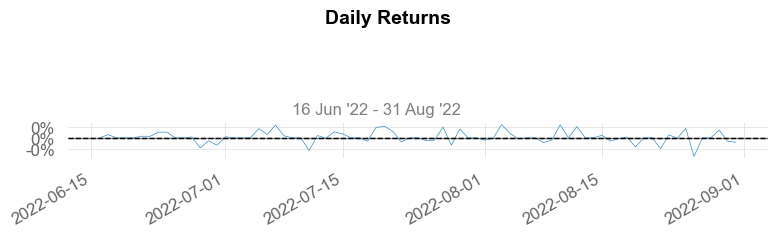

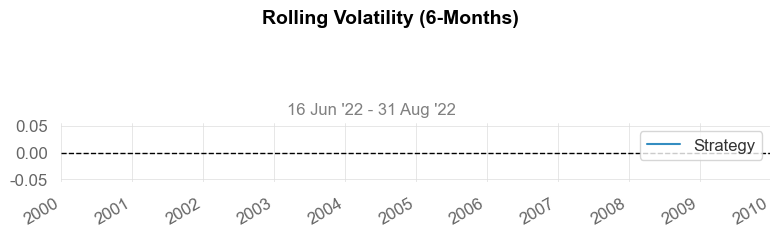

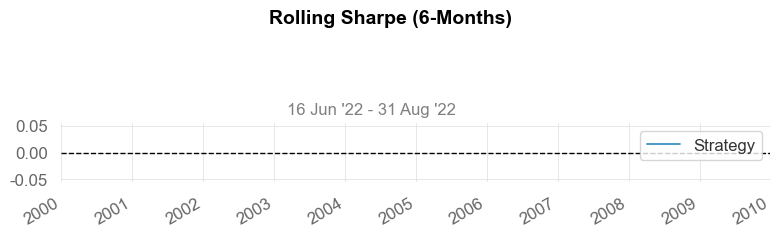

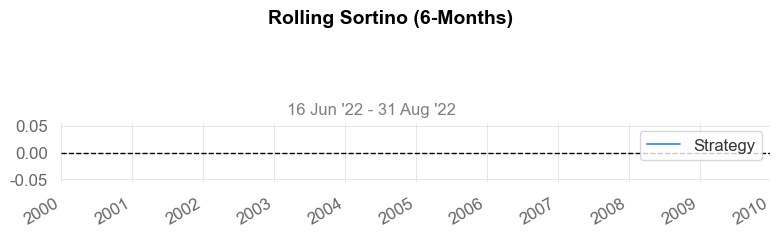

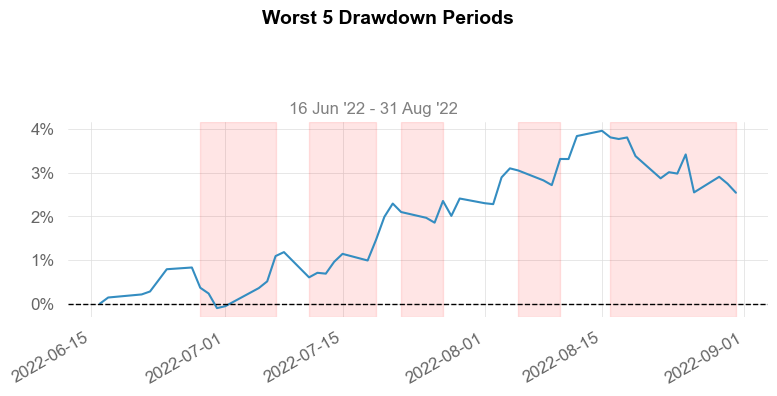

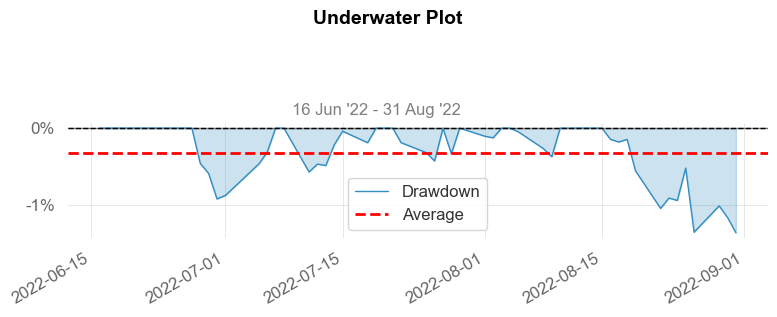

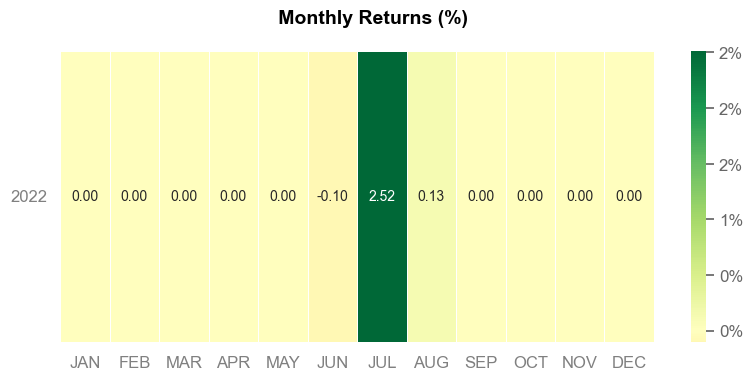

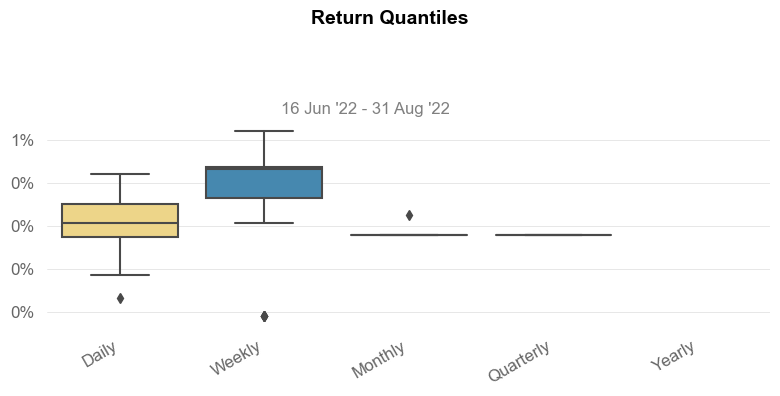

In [57]:
ModelwSentiment(tickers_to_predict=['TSLA'])

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_1118/1552830259.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tickers_to_predict, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

initial weights
Index(['META', 'AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL',
       'DIS', 'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE',
       'CMCSA', 'QCOM', 'META'],
      dtype='object')
betas.columns
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL', 'DIS',
       'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA',
       'QCOM', 'META'],
      dtype='object')
betas.columns after dropping
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL', 'DIS',
       'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA',
       'QCOM'],
      dtype='object')
weights.columns after dropping
Index(['AAPL', 'MSFT', 'GOOG', 'GOOGL', 'V', 'NVDA', 'MA', 'ORCL', 'DIS',
       'AVGO', 'TMUS', 'ACN', 'CSCO', 'CRM', 'VZ', 'TXN', 'ADBE', 'CMCSA',
       'QCOM'],
      dtype='object')
weights
                AAPL      MSFT      GOOG     GOOGL         V      NVDA  \
Date                                                    

                           Strategy
-------------------------  ----------
Start Period               2022-06-16
End Period                 2022-08-31
Risk-Free Rate             2.0%
Time in Market             99.0%

Cumulative Return          1.99%
CAGR﹪                     9.9%

Sharpe                     1.35
Prob. Sharpe Ratio         73.79%
Smart Sharpe               1.25
Sortino                    2.13
Smart Sortino              1.98
Sortino/√2                 1.51
Smart Sortino/√2           1.4
Omega                      1.25

Max Drawdown               -1.58%
Longest DD Days            22
Volatility (ann.)          5.57%
Calmar                     6.28
Skew                       0.16
Kurtosis                   0.33

Expected Daily %           0.04%
Expected Monthly %         0.66%
Expected Yearly %          1.99%
Kelly Criterion            13.17%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.54%
Expected Shortfall (cVaR)  -0.54%

Max Consecutive Wins       7
Max 

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2022-08-16  2022-08-26  2022-08-31    15     -1.577517         -1.560159
2  2022-07-22  2022-07-26  2022-08-02    11     -1.449669         -0.934868
3  2022-06-27  2022-07-01  2022-07-19    22     -1.002022         -0.873615
4  2022-08-05  2022-08-09  2022-08-10     5     -0.450513         -0.089158
5  2022-06-17  2022-06-17  2022-06-21     4     -0.150508          0.000000

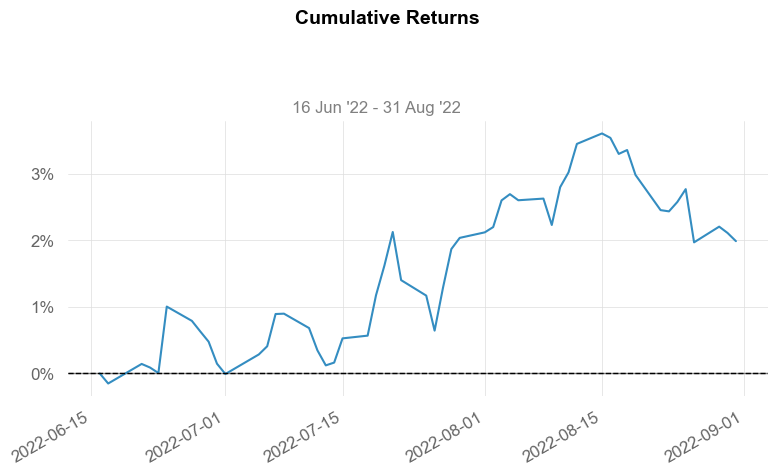

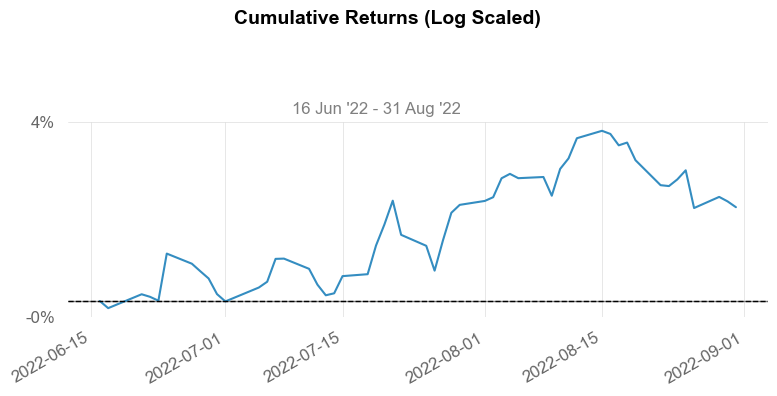

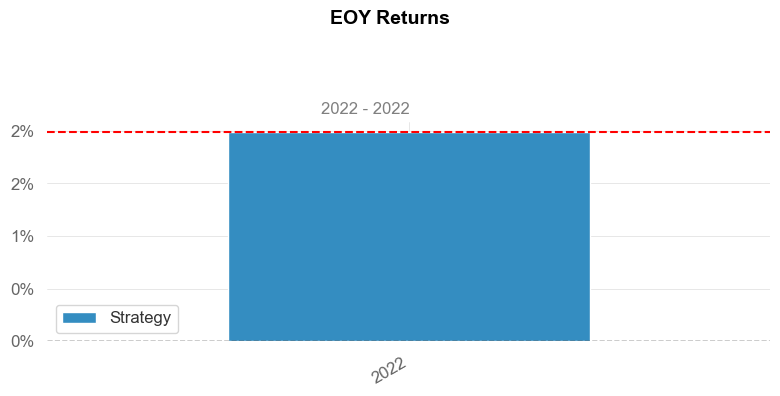

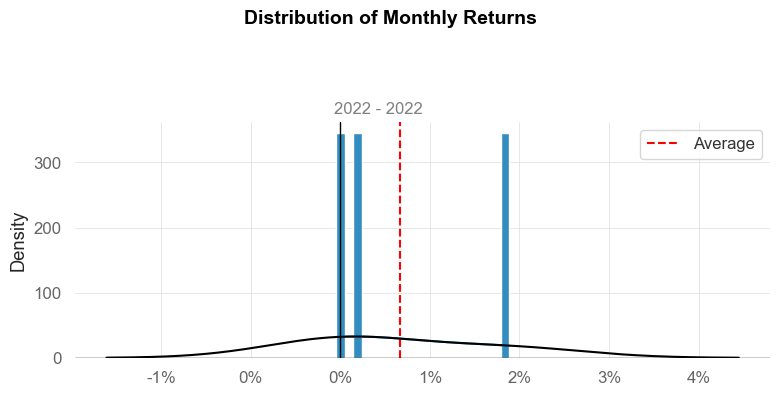

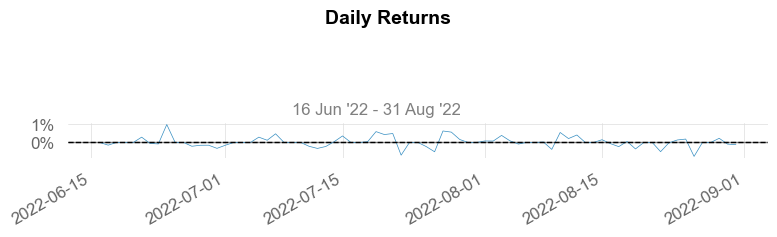

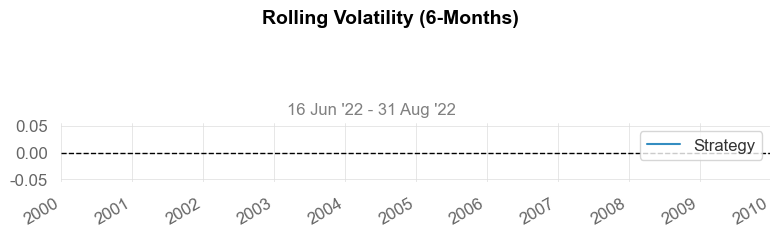

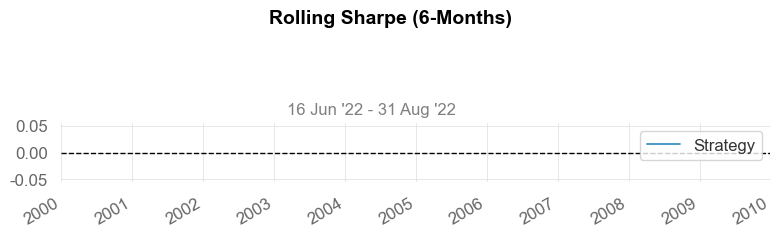

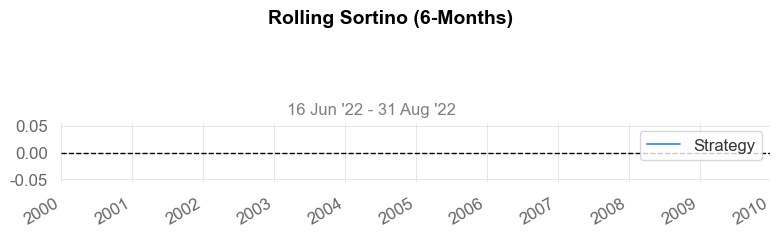

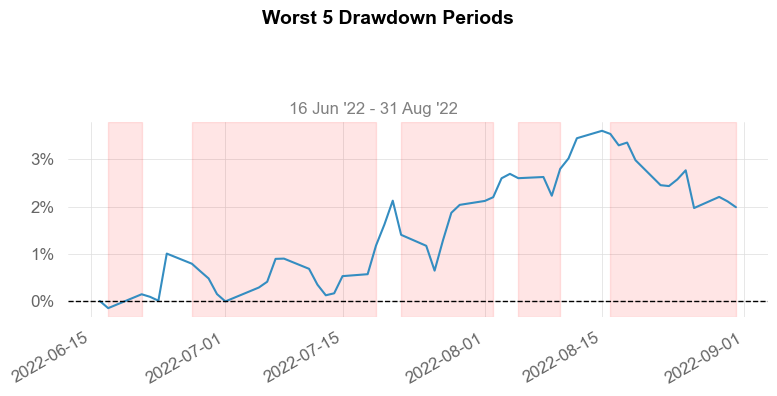

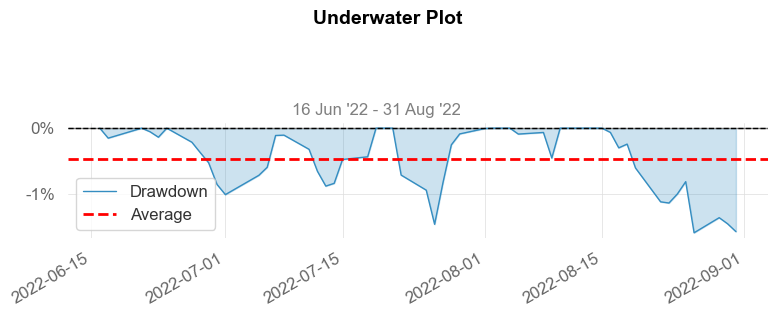

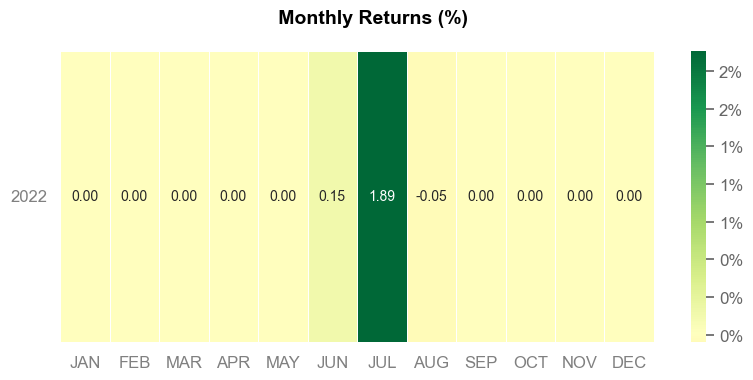

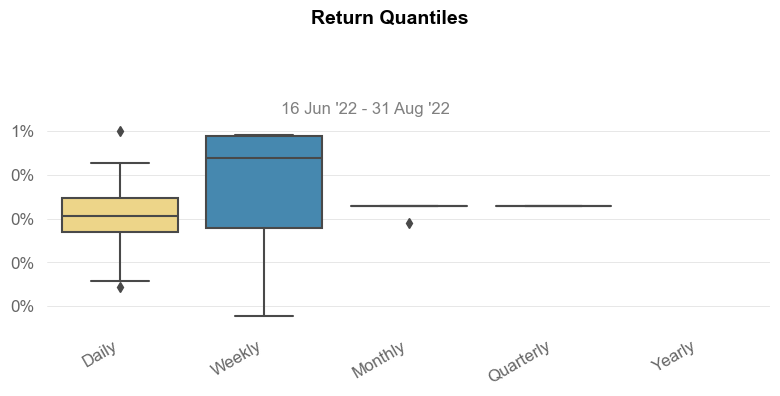

In [50]:
ModelwSentiment(tickers_to_predict=['META'])

# Grid Search

In [38]:
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from tqdm import tqdm

def logPriceFromRets(yhist):
    return np.log(np.cumprod(1+yhist))

def ModelwSentimentIter(tickers_to_predict=['AAPL'], 
        tickers_as_predictors=['top20_it_comm_stocks'], 
        sentiment_filepath = '../Data/3_Predictions/Unstructured_Data/rf_regressor/returns', sentiment_file = '/finbert_pred_returns_rfr_test.csv', 
        window = 120, lookback = 30, thresh = 1, intercept = False):
    retsSpreads = []
    for tick in tqdm(tickers_to_predict):
        #TODO: read from csv file instead of pulling live data to match the sentiment predictions by Elton
        yhist = readDailyReturnsFromCsv([tick])
        yhist.index = pd.to_datetime(yhist.index, utc=True).date
        yhist.index.rename('Date', inplace=True)


        # returns data
        Xhist_rets = readDailyReturnsFromCsv(tickers_as_predictors)
        if tick in Xhist_rets.columns:
            Xhist_rets.drop(columns=tick, inplace=True)
        Xhist_rets.index = pd.to_datetime(Xhist_rets.index, utc=True).date
        Xhist_rets.index.rename('Date', inplace=True)

        # sentiment data
        Xhist_sent = pd.read_csv(sentiment_filepath + sentiment_file, index_col=0)[tickers_to_predict]
        Xhist_sent.index = pd.to_datetime(Xhist_sent.index, utc=True).date
        Xhist_sent.index.rename('Date', inplace=True)

        # merge only on the dates that overlap
        Xhist = Xhist_rets.merge(Xhist_sent, how='inner', left_index=True, right_index=True, suffixes=('_rets','_sent'))
        yhist = yhist.loc[Xhist.index,:]

        Xyhist = pd.concat([Xhist, yhist], axis=1)
        # get betas
        if intercept:
            ols = RollingOLS(yhist, sm.add_constant(Xhist), window=window).fit()
        else:
            #TODO: add sentiment here
            ols = RollingOLS(yhist, Xhist, window=window).fit()
        betas = ols.params.dropna()
        # get weights
        if intercept:
            spread = yhist[tick] - (betas * sm.add_constant(Xhist)).sum(1)
            weights = sm.add_constant(betas.drop('const', axis=1)).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        else:
            #TODO: add sentiment here
            # spread is the residuals
            spread = yhist[tick] - (betas * (Xhist)).sum(1)
            weights = sm.add_constant(betas).rename({'const':tick}, axis=1)
            weights = weights.div(weights.abs().sum(1), axis=0)
        # print('ols.rsquared', ols.rsquared)
        zscore = (spread - spread.ewm(lookback).mean())/spread.ewm(lookback).std()
        signals = -(zscore>thresh).astype(int) + (zscore<thresh).astype(int)
        # drop predicted sentiment data as tradeable stock
        if tick in betas.columns:
            betas.drop(columns=tick, inplace=True)
        if tick in weights.columns:
            weights.drop(columns=tick, inplace=True)
        retsSpreads.append((weights.mul(signals,0).shift(1) * 
                            Xyhist.reindex(betas.index).dropna()).sum(1))
    retsSpreads = pd.DataFrame(retsSpreads).T.reindex(betas.index).dropna().reset_index()

    retsSpreads['Date'] = pd.DatetimeIndex(retsSpreads['Date']).tz_localize(None)
    retsSpreads.index = retsSpreads['Date']
    retsSpreads.drop(columns=['Date'], inplace=True)
    sharpe = qs.stats.sharpe(retsSpreads.mean(1), rf=0.02)
    print(sharpe)
    return sharpe
    # qs.reports.full(retsSpreads.mean(1), rf=0.02)
# , benchmark='SPY', match_dates=True)

In [37]:
ModelwSentimentIter()

  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/1154261835.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

0.22495892549345683


In [31]:
import itertools

In [35]:
for p in itertools.product(windows, intercepts):
    print(p)

(90, False)
(90, True)
(120, False)
(120, True)
(150, False)
(150, True)


In [41]:
windows = [90, 120, 150]
z_lookbacks = [15, 30, 45]
sentiment_files = ['/finbert_pred_returns_rfr_test.csv', '/flair_pred_returns_rfr_test.csv', '/vader_pred_returns_rfr_test.csv', '/stacked_pred_returns_rfr_test.csv']
intercepts = [False, True]
thresh = [0.75, 1, 1.5, 2]
tickers_sets_to_predict = [['AAPL', 'TSLA', 'META'], ['META', 'TSLA'], ['META'], ['TSLA'], ['AAPL']]

search_path = []
best_params = tuple()
best_Sharpe = 0
search_df = pd.DataFrame(columns=['tickers_to_predict', 'sentiment_filepath', 'window', 'lookback', 'thresh', 'intercept'])
for params in itertools.product(tickers_sets_to_predict, sentiment_files, windows, z_lookbacks, thresh, intercepts):
    ts, s, w, z, t, i = params
    sharpe = ModelwSentimentIter(tickers_to_predict=ts, sentiment_file=s, window=w, lookback=z, thresh=t, intercept=i)
    performance = list(params).append(sharpe)
    search_path.append(performance)
    if sharpe > best_Sharpe:
        best_Sharpe = sharpe
        best_params = params
    print('params:', params)
    print('sharpe', sharpe)
    print('best_Sharpe',best_Sharpe)

    

  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.45it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.59it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.0410900645549064
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -1.0410900645549064
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.7905047699085269
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -0.7905047699085269
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.99it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.8799353153096905
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -0.8799353153096905
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.99it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.21it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.8776622414050439
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -0.8776622414050439
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.75it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.5172995035813392
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -1.5172995035813392
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.95it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.5148339670254363
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -1.5148339670254363
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.95it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3813900254614362
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.3813900254614362
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.28it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.32it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3712918349084038
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.3712918349084038
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.57it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.03it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1936945966750743
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -1.1936945966750743
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.53it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1812458664899363
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -1.1812458664899363
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.7017259771515401
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -0.7017259771515401
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.40it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.04it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.7635725011190508
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -0.7635725011190508
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.39it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3778029632661353
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -1.3778029632661353
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:01<00:00,  1.47it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3709721333755174
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -1.3709721333755174
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:01,  1.84it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.30it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.4227944318996102
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.4227944318996102
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.4108226184848218
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.4108226184848218
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.21it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3393974829737518
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -1.3393974829737518
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.36it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.52it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.2488413638135842
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -1.2488413638135842
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.36it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3892598625556098
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -1.3892598625556098
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.186411637189366
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -1.186411637189366
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.03it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.2078374762073738
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -1.2078374762073738
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.2000244081330236
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -1.2000244081330236
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.46it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.342551085601375
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.342551085601375
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.330443567443168
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.330443567443168
best_Sharpe 0


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.01it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.4557856544201289
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 1.4557856544201289
best_Sharpe 1.4557856544201289


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.5869743427566503
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 1.5869743427566503
best_Sharpe 1.5869743427566503


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.63it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.18it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.6790017882396235
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.6790017882396235
best_Sharpe 1.6790017882396235


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.72183709179658
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 1.72183709179658
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8943341798018912
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.8943341798018912
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.14it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.9225283974282783
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.9225283974282783
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.53it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8591855232412736
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.8591855232412736
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.94it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8813215061755769
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.8813215061755769
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.47it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.36it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.3436518942209452
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 1.3436518942209452
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:01<00:00,  1.57it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.3973829683886956
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.3973829683886956
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.11it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.2097774937439743
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.2097774937439743
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.90it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.1724910067783822
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.1724910067783822
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.0855699210979164
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 1.0855699210979164
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.87it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.1144689731155768
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 1.1144689731155768
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.39it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8591855232412736
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.8591855232412736
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.52it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8813215061755769
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.8813215061755769
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.08it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:01<00:00,  1.75it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8175417634751512
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 0.8175417634751512
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.64it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8651327867055351
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 0.8651327867055351
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.86it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.188387166113639
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.188387166113639
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.2178333952940938
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.2178333952940938
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.04it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.16it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.0855699210979164
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 1.0855699210979164
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.1144689731155768
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.1144689731155768
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8591855232412736
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.8591855232412736
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.15it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8813215061755769
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.8813215061755769
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.20it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.386940428636643
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -3.386940428636643
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.45it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.98it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.3678205515810364
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -3.3678205515810364
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.09it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.7362137929776487
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.7362137929776487
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.13it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.62it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.648554614170519
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -2.648554614170519
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2777857408843816
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.2777857408843816
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.12it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2797545782817874
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.2797545782817874
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.56it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.26it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2777857408843816
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.2777857408843816
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.39it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.13it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2797545782817874
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.2797545782817874
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.6266211767607404
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -3.6266211767607404
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.18it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.6136114039925835
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -3.6136114039925835
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.44it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.82it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.6555920992595383
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -2.6555920992595383
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.648554614170519
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -2.648554614170519
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.36it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.01it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2777857408843816
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.2777857408843816
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.18it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.03it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2797545782817874
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.2797545782817874
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.36it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.37it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2777857408843816
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.2777857408843816
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.00it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2797545782817874
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.2797545782817874
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.77it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.95it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.6266211767607404
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -3.6266211767607404
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.57it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.95it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.6136114039925835
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -3.6136114039925835
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.6555920992595383
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -2.6555920992595383
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:01,  1.93it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.70it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.648554614170519
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -2.648554614170519
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.20it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2777857408843816
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.2777857408843816
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.09it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.84it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2797545782817874
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.2797545782817874
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2777857408843816
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.2777857408843816
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.67it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.2797545782817874
params: (['AAPL', 'TSLA', 'META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.2797545782817874
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.9547110630484275
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -1.9547110630484275
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.9306081868578613
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -1.9306081868578613
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.63it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.7321493010212765
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -1.7321493010212765
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.6929062022138743
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -1.6929062022138743
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.14it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.9654630151213434
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.9654630151213434
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.63it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.82it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.9431745707604877
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.9431745707604877
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.39it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.44it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3453487046836718
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.3453487046836718
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.82it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.63it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3020987842183214
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.3020987842183214
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.39it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.53it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.6108443978816225
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -1.6108443978816225
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.12it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.5022105510859352
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -1.5022105510859352
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.9074102958146673
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -0.9074102958146673
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.13it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.46it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.8864904189311847
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -0.8864904189311847
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.31it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1250898641098828
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -1.1250898641098828
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.0876422547810367
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -1.0876422547810367
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.15it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.04it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.2775612496572875
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.2775612496572875
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.46it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.88it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.2650472021853643
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.2650472021853643
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.46it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.7029358764731837
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -1.7029358764731837
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.35it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.6045326121226908
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -1.6045326121226908
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.52it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1010128486092263
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -1.1010128486092263
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.09it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.0483798780749862
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -1.0483798780749862
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.90it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1250898641098828
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -1.1250898641098828
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.0876422547810367
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -1.0876422547810367
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.75it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3028694781220986
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.3028694781220986
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.62it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.87it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.2650472021853643
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.2650472021853643
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.64it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8062105226624222
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 0.8062105226624222
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8304800397409543
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 0.8304800397409543
best_Sharpe 1.72183709179658


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:01,  1.45it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.47it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.8057996702565275
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.8057996702565275
best_Sharpe 1.8057996702565275


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.03it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.836390237986541
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 1.836390237986541
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8084898583248753
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.8084898583248753
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8485881426215075
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.8485881426215075
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.49it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7326898086229312
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.7326898086229312
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.45it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.08it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.765615273816274
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.765615273816274
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.21it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.37it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.2364341039929216
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 1.2364341039929216
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.42it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.261366906817958
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.261366906817958
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.22it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.2756241940566289
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.2756241940566289
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.62it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.04it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.3092678081626394
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.3092678081626394
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.02it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.22it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8312947973279395
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.8312947973279395
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.006827765725576
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 1.006827765725576
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7326898086229312
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.7326898086229312
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.765615273816274
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.765615273816274
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.85it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.5176379798570339
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 1.5176379798570339
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.87it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.08it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.5511271634405892
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 1.5511271634405892
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.25it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.1313924054585047
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.1313924054585047
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.21it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.0376618245031397
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.0376618245031397
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.35it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7555951286825265
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.7555951286825265
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.44it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7864848249112784
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.7864848249112784
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7326898086229312
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.7326898086229312
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.765615273816274
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.765615273816274
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.90it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.8364439316694834
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -2.8364439316694834
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.26it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.78121664164317
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -2.78121664164317
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.40it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.5001300442468537
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -2.5001300442468537
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.15it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.4646017279034087
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -2.4646017279034087
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.89it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.006133688455442
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.006133688455442
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.36it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.9809627187765275
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -2.9809627187765275
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.43it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.006133688455442
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.006133688455442
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.9809627187765275
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -2.9809627187765275
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.8364439316694834
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -2.8364439316694834
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.31it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.536533243229664
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -2.536533243229664
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.5001300442468537
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -2.5001300442468537
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.47it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.4646017279034087
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -2.4646017279034087
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.43it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.50it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.006133688455442
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.006133688455442
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.87it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.9809627187765275
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -2.9809627187765275
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.26it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.44it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.006133688455442
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.006133688455442
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.04it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.40it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.9809627187765275
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -2.9809627187765275
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.13it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.39it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.8364439316694834
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -2.8364439316694834
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.143212849764336
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -3.143212849764336
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.09it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.82it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.5001300442468537
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -2.5001300442468537
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.63it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.4646017279034087
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -2.4646017279034087
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.84it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.59it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.006133688455442
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.006133688455442
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.20it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.9809627187765275
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -2.9809627187765275
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.99it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.30it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.006133688455442
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.006133688455442
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.13it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.9809627187765275
params: (['AAPL', 'TSLA', 'META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -2.9809627187765275
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.56it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.093381313570705
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -1.093381313570705
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1301750948303264
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -1.1301750948303264
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.09it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.76it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.8770351799125177
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -0.8770351799125177
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.87it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.90it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.8679312427327226
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -0.8679312427327226
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1288949850989134
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -1.1288949850989134
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.12384881239451
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -1.12384881239451
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.25it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1942414397916108
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.1942414397916108
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.91it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.182460336473359
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.182460336473359
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.59it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3383805795321644
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -1.3383805795321644
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.95it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.46it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.2730223579322182
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -1.2730223579322182
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.5503009966047563
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -0.5503009966047563
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.73555060661902
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -0.73555060661902
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.20it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1288949850989134
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -1.1288949850989134
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.92it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.31it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1745085111469395
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -1.1745085111469395
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1852687395935608
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.1852687395935608
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.87it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1762025800180125
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.1762025800180125
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.42it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.00it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.9135618520887652
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -0.9135618520887652
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.0786779924085124
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -1.0786779924085124
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.14it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.169547895627631
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -1.169547895627631
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1602182765452467
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -1.1602182765452467
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.26it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1966313770678272
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -1.1966313770678272
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.94it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1855015748596243
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -1.1855015748596243
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1852687395935608
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.1852687395935608
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.25it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1762025800180125
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.1762025800180125
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.36it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.5718417955252455
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 0.5718417955252455
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.88it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.77it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8718509055989488
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 0.8718509055989488
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.1372648587035696
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.1372648587035696
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.57it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.143994435098823
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 1.143994435098823
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.18it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.9909196421119271
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.9909196421119271
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.76it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.0011844949244866
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.0011844949244866
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.89it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.75it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7967032434533816
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.7967032434533816
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.70it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.04it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7993710386972894
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.7993710386972894
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.03it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.6378320780866723
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 0.6378320780866723
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.95it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.70it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.656334903645637
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 0.656334903645637
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.04it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.573242109812455
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.573242109812455
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.43it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.3661444364765856
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.3661444364765856
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7967032434533816
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.7967032434533816
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.08it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7993710386972894
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 0.7993710386972894
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.98it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.35it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7967032434533816
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.7967032434533816
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7993710386972894
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.7993710386972894
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.32it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.9595684747661253
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 0.9595684747661253
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.92it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.1953980618748337
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 1.1953980618748337
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.077888941535281
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.077888941535281
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.0882690198884826
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.0882690198884826
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.42it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7967032434533816
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.7967032434533816
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.28it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7993710386972894
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.7993710386972894
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7967032434533816
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.7967032434533816
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.7993710386972894
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.7993710386972894
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.89it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.9275803242522542
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -2.9275803242522542
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.941287312915961
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -2.941287312915961
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.26it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.581170815100725
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -2.581170815100725
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.5920540527902567
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -2.5920540527902567
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.078985791773145
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.078985791773145
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.42it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.0914502503673176
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.0914502503673176
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.56it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.078985791773145
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.078985791773145
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.20it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.94it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.0914502503673176
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.0914502503673176
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.63it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.04it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.9275803242522542
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -2.9275803242522542
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.67it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.611792522085765
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -2.611792522085765
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.078985791773145
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -3.078985791773145
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.84it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.0914502503673176
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -3.0914502503673176
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.28it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.86it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.078985791773145
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.078985791773145
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.30it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.0914502503673176
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.0914502503673176
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.59it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.078985791773145
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.078985791773145
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.52it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.0914502503673176
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.0914502503673176
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.37it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.85it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.5868165466716926
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -3.5868165466716926
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.04it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.53it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.3171323134642896
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -3.3171323134642896
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.08it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.078985791773145
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -3.078985791773145
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.28it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.0914502503673176
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -3.0914502503673176
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.078985791773145
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.078985791773145
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.0914502503673176
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.0914502503673176
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.12it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.49it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.078985791773145
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.078985791773145
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.64it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-3.0914502503673176
params: (['AAPL', 'TSLA', 'META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.0914502503673176
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.46it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.6949364261693597
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -0.6949364261693597
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.40it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.43it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.5912530091655872
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -0.5912530091655872
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.43it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.11it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.22331884249882936
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -0.22331884249882936
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.20it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.23060565405364028
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -0.23060565405364028
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.11it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1476480669710818
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -1.1476480669710818
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.8986320616645427
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.8986320616645427
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3871958374768958
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.3871958374768958
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:01,  1.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:01<00:00,  1.99it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3587994916475956
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.3587994916475956
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.21it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.4093299344469775
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -0.4093299344469775
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.42it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.91it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.37133640414285846
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -0.37133640414285846
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.03it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.64926310253993
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -0.64926310253993
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.02it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.6287296776805248
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -0.6287296776805248
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.37it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.18it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1476480669710818
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -1.1476480669710818
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.93it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.57it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1249869831470984
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -1.1249869831470984
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.86it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.31it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3871958374768958
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.3871958374768958
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.08it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.52it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3587994916475956
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.3587994916475956
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.49it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.93it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.7528276364132351
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -0.7528276364132351
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.92it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.95it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.5601327802399776
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -0.5601327802399776
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.7211110135643082
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -0.7211110135643082
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.37it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.6919417533318112
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -0.6919417533318112
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.99it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.2546947705885303
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -1.2546947705885303
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.28it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.18it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.2323000807062048
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -1.2323000807062048
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3871958374768958
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.3871958374768958
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.56it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.3587994916475956
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.3587994916475956
best_Sharpe 1.836390237986541


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.59it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

2.0095635437586044
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 2.0095635437586044
best_Sharpe 2.0095635437586044


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.08it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

2.3351024877288147
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 2.3351024877288147
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.8246635032657499
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.8246635032657499
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.77it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.8383642623595773
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 1.8383642623595773
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.26it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8871929199533692
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.8871929199533692
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.98it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.01it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.9793899785482262
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.9793899785482262
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.01it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8916328209888266
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.8916328209888266
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.50it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.9816700596758502
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.9816700596758502
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.63it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.6213855358660105
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 1.6213855358660105
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.35it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.9380305923909762
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.9380305923909762
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.36it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.37it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.1993211081320245
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.1993211081320245
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.35it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.2950486485254402
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.2950486485254402
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.30it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8077786173016842
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.8077786173016842
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.88it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8403750656951798
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 0.8403750656951798
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.09it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.53it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8916328209888266
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.8916328209888266
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.85it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.9816700596758502
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.9816700596758502
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.2871337272738201
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 1.2871337272738201
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  2.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.3973943418868062
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 1.3973943418868062
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.21it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.0562426552988158
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.0562426552988158
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

1.150066280982934
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.150066280982934
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.25it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8077786173016842
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.8077786173016842
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  2.62it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8979777082696279
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.8979777082696279
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.8916328209888266
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.8916328209888266
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.12it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

0.9816700596758502
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.9816700596758502
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.86it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  3.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.1584333699805642
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -1.1584333699805642
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.0613157881394162
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -1.0613157881394162
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.35it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.4303167870965385
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -2.4303167870965385
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.50it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.77it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.3756083600536284
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -2.3756083600536284
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.887695198078454
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -2.887695198078454
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.98it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.839972232489627
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -2.839972232489627
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.63it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.887695198078454
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -2.887695198078454
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.91it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.839972232489627
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -2.839972232489627
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.9660430646213222
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -0.9660430646213222
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.22it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-0.8766520990257175
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -0.8766520990257175
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.99it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  4.91it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.4303167870965385
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -2.4303167870965385
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  3.16it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  1.91it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.3756083600536284
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -2.3756083600536284
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.15it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.01it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.887695198078454
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -2.887695198078454
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.53it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.839972232489627
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -2.839972232489627
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.43it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.887695198078454
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -2.887695198078454
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.56it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.839972232489627
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -2.839972232489627
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.62it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.7113376083314538
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -1.7113376083314538
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.85it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.02it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-1.543852407273127
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -1.543852407273127
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.4303167870965385
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -2.4303167870965385
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.88it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.85it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.3756083600536284
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -2.3756083600536284
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.59it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.887695198078454
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -2.887695198078454
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  4.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.31it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.839972232489627
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -2.839972232489627
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  6.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  6.43it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.887695198078454
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -2.887695198078454
best_Sharpe 2.3351024877288147


  0%|          | 0/3 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 33%|███▎      | 1/3 [00:00<00:00,  5.50it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 67%|██████▋   | 2/3 [00:00<00:00,  5.77it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

-2.839972232489627
params: (['AAPL', 'TSLA', 'META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -2.839972232489627
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


0.41301431694297164
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe 0.41301431694297164
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.87it/s]


-0.1580239858990955
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -0.1580239858990955
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.42it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


-0.14975868949028118
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -0.14975868949028118
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.91it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


-0.1473051137046428
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -0.1473051137046428
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


-0.9582838318666919
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.9582838318666919
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.32it/s]


-0.9559399544678442
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.9559399544678442
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


-1.0531204736134545
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.0531204736134545
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


-1.0396576700288251
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.0396576700288251
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.85it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


-0.6564700719100619
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -0.6564700719100619
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.84it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.33it/s]


-0.638190454773079
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -0.638190454773079
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  2.79it/s]


-0.640883688214841
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -0.640883688214841
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.28it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


-0.9717212231173928
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -0.9717212231173928
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.06it/s]


-1.0782874763771966
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -1.0782874763771966
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.28it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


-1.070079453446115
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -1.070079453446115
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.26it/s]


-0.9531542063071835
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -0.9531542063071835
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.78it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


-0.9458653196325373
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -0.9458653196325373
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.21it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


-0.07702386580891664
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -0.07702386580891664
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


-0.638190454773079
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -0.638190454773079
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


-0.7895247423594626
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -0.7895247423594626
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.95it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


-0.7883296209930228
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -0.7883296209930228
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


-0.8574484750674849
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.8574484750674849
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.20it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.28it/s]


-0.8445181574549053
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.8445181574549053
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


-0.9531542063071835
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -0.9531542063071835
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.84it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.73it/s]


-0.9458653196325373
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -0.9458653196325373
best_Sharpe 2.3351024877288147


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.12it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


2.7217273055674176
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 2.7217273055674176
best_Sharpe 2.7217273055674176


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.47it/s]


2.752442880245094
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 2.752442880245094
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


1.6726605841591713
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.6726605841591713
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.20it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


1.6885044258837614
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 1.6885044258837614
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.30it/s]


1.51141206079765
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 1.51141206079765
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


1.532617824836446
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.532617824836446
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


1.3648441795029296
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 1.3648441795029296
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


1.3747779943488485
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 1.3747779943488485
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.70it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.13it/s]


1.742174954516349
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 1.742174954516349
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


1.7668062909285858
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.7668062909285858
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


1.7667091094737795
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.7667091094737795
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


1.788225396595696
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.788225396595696
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.29it/s]


1.7589769875910342
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 1.7589769875910342
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


1.7756305203830582
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 1.7756305203830582
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.37it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.32it/s]


1.3648441795029296
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 1.3648441795029296
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


1.3747779943488485
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 1.3747779943488485
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


1.8398298163330702
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 1.8398298163330702
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.22it/s]


1.9093063071464835
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 1.9093063071464835
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.16it/s]


1.5541429390933406
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.5541429390933406
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


1.575651111116961
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.575651111116961
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.53it/s]


1.3648441795029296
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 1.3648441795029296
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.14it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


1.3747779943488485
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.3747779943488485
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


1.3648441795029296
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 1.3648441795029296
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.39it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


1.3747779943488485
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 1.3747779943488485
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.58it/s]


-1.0263337890174953
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -1.0263337890174953
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


-1.0259204340188923
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -1.0259204340188923
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.73it/s]


-3.6511901649008562
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.6511901649008562
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


-3.6577130263783175
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -3.6577130263783175
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


-2.895553508332678
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -2.895553508332678
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


-2.9029454408287885
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -2.9029454408287885
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.37it/s]


-2.895553508332678
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -2.895553508332678
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.56it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


-2.9029454408287885
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -2.9029454408287885
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.50it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.46it/s]


-3.6511901649008562
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -3.6511901649008562
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


-3.6577130263783175
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -3.6577130263783175
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.79it/s]


-1.9047067527797532
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -1.9047067527797532
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


-1.906678091787526
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -1.906678091787526
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


-2.895553508332678
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -2.895553508332678
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.87it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


-2.9029454408287885
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -2.9029454408287885
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.64it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


-2.895553508332678
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -2.895553508332678
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.64it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.69it/s]


-2.9029454408287885
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -2.9029454408287885
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


-3.6511901649008562
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -3.6511901649008562
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.59it/s]


-3.6577130263783175
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -3.6577130263783175
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.64it/s]


-1.9047067527797532
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -1.9047067527797532
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.11it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.63it/s]


-1.906678091787526
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -1.906678091787526
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.13it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


-2.895553508332678
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -2.895553508332678
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


-2.9029454408287885
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -2.9029454408287885
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.15it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


-2.895553508332678
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -2.895553508332678
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.82it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


-2.9029454408287885
params: (['META', 'TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -2.9029454408287885
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.99it/s]


-1.0527838370621552
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -1.0527838370621552
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.88it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


-1.0514594374493489
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -1.0514594374493489
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.09it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


-1.3833842253627524
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -1.3833842253627524
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.94it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.26it/s]


-1.3703387461155503
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -1.3703387461155503
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


-0.7091287880564078
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.7091287880564078
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.82it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.70it/s]


-0.5912650179977618
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.5912650179977618
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


-1.0675308496693277
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.0675308496693277
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.21it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


-1.0425608549398235
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.0425608549398235
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.88it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


-1.058849329549683
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -1.058849329549683
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


-1.0698266347818983
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -1.0698266347818983
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.92it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.96it/s]


-0.3591401936748396
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -0.3591401936748396
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.56it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


-0.3583142978762102
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -0.3583142978762102
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.47it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.76it/s]


-0.8675736923698739
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.8675736923698739
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


-0.8433076457012136
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.8433076457012136
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.08it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.37it/s]


-0.9614174468573006
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -0.9614174468573006
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.52it/s]


-0.9457952119754118
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -0.9457952119754118
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.52it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


-1.2961013465991458
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -1.2961013465991458
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.56it/s]


-1.2831516902369526
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -1.2831516902369526
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.76it/s]


-0.3591401936748396
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -0.3591401936748396
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  1.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  2.50it/s]


-0.3583142978762102
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -0.3583142978762102
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.54it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


-0.8675736923698739
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.8675736923698739
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.86it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.93it/s]


-0.8433076457012136
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.8433076457012136
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.47it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


-0.9614174468573006
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -0.9614174468573006
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


-0.9457952119754118
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -0.9457952119754118
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.64it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


1.5104432172853575
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 1.5104432172853575
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.44it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


1.5245286754925833
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 1.5245286754925833
best_Sharpe 2.752442880245094


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


2.8226383650257176
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 2.8226383650257176
best_Sharpe 2.8226383650257176


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.90it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.63it/s]


2.8366760592794713
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 2.8366760592794713
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.16it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.31it/s]


1.2784079311090386
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 1.2784079311090386
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


1.3202695985411985
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.3202695985411985
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.99it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


1.15344939861831
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 1.15344939861831
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.53it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


1.1853758092326268
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 1.1853758092326268
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


2.2476239739236634
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 2.2476239739236634
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


2.265995617976161
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 2.265995617976161
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.89it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


1.7890084064355112
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.7890084064355112
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.99it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.75it/s]


1.8229117641283608
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.8229117641283608
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.21it/s]


1.3150422031718014
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 1.3150422031718014
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.44it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


1.5748082918129083
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 1.5748082918129083
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.00it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.36it/s]


1.15344939861831
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 1.15344939861831
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.98it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


1.1853758092326268
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 1.1853758092326268
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.26it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


2.8226383650257176
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 2.8226383650257176
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.65it/s]


2.7511520236995053
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 2.7511520236995053
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.83it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


1.3150422031718014
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.3150422031718014
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.54it/s]


1.3529179869045984
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.3529179869045984
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.22it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


1.1902137234510521
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 1.1902137234510521
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.45it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


1.2181162520946502
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.2181162520946502
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.04it/s]


1.15344939861831
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 1.15344939861831
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


1.1853758092326268
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 1.1853758092326268
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.21it/s]


-1.2080897443153467
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -1.2080897443153467
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.63it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


-1.1904046354471334
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -1.1904046354471334
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.50it/s]


-1.6881433852848546
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -1.6881433852848546
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  1.03it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


-1.6763802733107678
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -1.6763802733107678
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


-2.517795707331431
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -2.517795707331431
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


-2.513637158314657
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -2.513637158314657
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.48it/s]


-2.517795707331431
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -2.517795707331431
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


-2.513637158314657
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -2.513637158314657
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.31it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.45it/s]


-1.2080897443153467
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -1.2080897443153467
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


-1.1904046354471334
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -1.1904046354471334
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


-1.6881433852848546
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -1.6881433852848546
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.90it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


-1.6763802733107678
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -1.6763802733107678
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.22it/s]


-2.517795707331431
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -2.517795707331431
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.09it/s]


-2.513637158314657
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -2.513637158314657
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.66it/s]


-2.517795707331431
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -2.517795707331431
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


-2.513637158314657
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -2.513637158314657
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


-1.2080897443153467
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -1.2080897443153467
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


-2.2964894239211344
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -2.2964894239211344
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.06it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.18it/s]


-1.6881433852848546
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -1.6881433852848546
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.82it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


-1.6763802733107678
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -1.6763802733107678
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.95it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


-2.517795707331431
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -2.517795707331431
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.84it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.73it/s]


-2.513637158314657
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -2.513637158314657
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


-2.517795707331431
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -2.517795707331431
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


-2.513637158314657
params: (['META', 'TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -2.513637158314657
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


-0.028245984871723914
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -0.028245984871723914
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.51it/s]


-0.5106955265363374
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -0.5106955265363374
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.65it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.84it/s]


-0.2775601478455957
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -0.2775601478455957
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.27it/s]


-0.20661552034858705
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -0.20661552034858705
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.40it/s]


-0.6654228842094365
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.6654228842094365
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.99it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.36it/s]


-0.6496234804858964
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.6496234804858964
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.37it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


-0.9461286294544133
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -0.9461286294544133
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.70it/s]


-0.9259957635418664
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -0.9259957635418664
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.85it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


-0.9065228377157845
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -0.9065228377157845
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.88it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.16it/s]


-0.6434528969809185
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -0.6434528969809185
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.06it/s]


-0.04679647005737524
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -0.04679647005737524
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


-0.46371522003702087
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -0.46371522003702087
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.21it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


-0.6654228842094365
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.6654228842094365
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.89it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


-0.6496234804858964
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.6496234804858964
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


-0.8591097992421558
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -0.8591097992421558
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


-0.8419737833673722
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -0.8419737833673722
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.11it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


0.43655474960546375
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe 0.43655474960546375
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.92it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


-0.5259105867785011
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -0.5259105867785011
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


-0.5450394349152032
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -0.5450394349152032
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


-0.7762285494312847
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -0.7762285494312847
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.30it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


-0.7534364676340658
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.7534364676340658
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.03it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.33it/s]


-0.917877979574942
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.917877979574942
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


-0.8591097992421558
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -0.8591097992421558
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.56it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.10it/s]


-0.8419737833673722
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -0.8419737833673722
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


1.5188923671453887
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 1.5188923671453887
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


2.7050684451213916
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 2.7050684451213916
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.47it/s]


1.6840678271914786
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.6840678271914786
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.62it/s]


1.7015098175753303
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 1.7015098175753303
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.74it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


1.5881165924857015
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 1.5881165924857015
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.62it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


1.6083442669245374
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.6083442669245374
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


1.2878979389531204
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 1.2878979389531204
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.88it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.26it/s]


1.2958248881414918
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 1.2958248881414918
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.89it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


1.5243654064623875
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 1.5243654064623875
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.49it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


1.3442990944588966
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.3442990944588966
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


2.332338481902071
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 2.332338481902071
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.52it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.58it/s]


2.1297939968988446
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 2.1297939968988446
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.43it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


1.2878979389531204
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 1.2878979389531204
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.55it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.23it/s]


1.2958248881414918
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 1.2958248881414918
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.57it/s]


1.2878979389531204
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 1.2878979389531204
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.83it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.07it/s]


1.2958248881414918
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 1.2958248881414918
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.19it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.20it/s]


1.3176531224369243
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 1.3176531224369243
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.67it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.62it/s]


2.229636697969826
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 2.229636697969826
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.41it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


1.6426723567587356
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.6426723567587356
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.28it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.39it/s]


1.6632102667504622
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.6632102667504622
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


1.2878979389531204
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 1.2878979389531204
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.75it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


1.2958248881414918
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.2958248881414918
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.93it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


1.2878979389531204
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 1.2878979389531204
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.59it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.05it/s]


1.2958248881414918
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 1.2958248881414918
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


-1.4810929055979827
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -1.4810929055979827
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.14it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.34it/s]


-1.4802597153944332
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -1.4802597153944332
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


-1.9683764249220883
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -1.9683764249220883
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.32it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.53it/s]


-1.9708445947616464
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -1.9708445947616464
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.08it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.56it/s]


-2.7952044136885648
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -2.7952044136885648
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


-2.797887319021175
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -2.797887319021175
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.00it/s]


-2.7952044136885648
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -2.7952044136885648
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.52it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.48it/s]


-2.797887319021175
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -2.797887319021175
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.39it/s]


-1.4810929055979827
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -1.4810929055979827
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.80it/s]


-1.4802597153944332
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -1.4802597153944332
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.64it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.23it/s]


-2.7952044136885648
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -2.7952044136885648
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.23it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


-2.797887319021175
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -2.797887319021175
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.95it/s]


-2.7952044136885648
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -2.7952044136885648
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.14it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.98it/s]


-2.797887319021175
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -2.797887319021175
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.10it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


-2.7952044136885648
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -2.7952044136885648
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.47it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


-2.797887319021175
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -2.797887319021175
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.93it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


-2.939715957286955
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -2.939715957286955
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.77it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


-2.9426027331591342
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -2.9426027331591342
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.88it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.06it/s]


-2.7952044136885648
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -2.7952044136885648
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.51it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


-2.797887319021175
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -2.797887319021175
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.60it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.82it/s]


-2.7952044136885648
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -2.7952044136885648
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.68it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


-2.797887319021175
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -2.797887319021175
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


-2.7952044136885648
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -2.7952044136885648
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.85it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.72it/s]


-2.797887319021175
params: (['META', 'TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -2.797887319021175
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.86it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.91it/s]


0.34400255805413404
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe 0.34400255805413404
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.25it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.45it/s]


0.4719158846324783
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe 0.4719158846324783
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.67it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


0.237448246584709
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe 0.237448246584709
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.72it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


0.2792469565226454
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe 0.2792469565226454
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.79it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.02it/s]


-0.5776863908855686
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.5776863908855686
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.73it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.66it/s]


-0.17998577742838684
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.17998577742838684
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.61it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.35it/s]


-1.0154449763769764
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.0154449763769764
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.24it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


-0.9873195146716254
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -0.9873195146716254
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.81it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.60it/s]


0.36060709462604995
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe 0.36060709462604995
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.26it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.36it/s]


0.3691012850955934
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe 0.3691012850955934
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.46it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.49it/s]


0.3679495908168343
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe 0.3679495908168343
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.57it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.28it/s]


0.18135380192430042
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe 0.18135380192430042
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.98it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


-0.7985649833331194
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.7985649833331194
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


-0.769692476010804
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.769692476010804
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.70it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.89it/s]


-1.0154449763769764
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.0154449763769764
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.34it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


-0.9873195146716254
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -0.9873195146716254
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.33it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


-0.08733637255468028
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -0.08733637255468028
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.92it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


0.006788543233281072
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe 0.006788543233281072
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.70it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


0.1456374739710711
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe 0.1456374739710711
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.60it/s]


0.17828534509678617
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe 0.17828534509678617
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.67it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.95it/s]


-0.7985649833331194
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.7985649833331194
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.16it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


-0.7806958174220047
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.7806958174220047
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.05it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.17it/s]


-1.0154449763769764
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.0154449763769764
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.31it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.43it/s]


-0.9873195146716254
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -0.9873195146716254
best_Sharpe 2.8366760592794713


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.97it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


2.8460928571031285
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 2.8460928571031285
best_Sharpe 2.8460928571031285


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.49it/s]


3.290546689688693
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 3.290546689688693
best_Sharpe 3.290546689688693


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.96it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.10it/s]


3.130674211674628
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 3.130674211674628
best_Sharpe 3.290546689688693


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.29it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.25it/s]


3.0252535207488913
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 3.0252535207488913
best_Sharpe 3.290546689688693


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.07it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.26it/s]


1.5080971097353668
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 1.5080971097353668
best_Sharpe 3.290546689688693


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


1.546449894090807
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.546449894090807
best_Sharpe 3.290546689688693


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.83it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.93it/s]


1.3866185477722022
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 1.3866185477722022
best_Sharpe 3.290546689688693


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.80it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.68it/s]


1.415059482335762
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 1.415059482335762
best_Sharpe 3.290546689688693


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.66it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.07it/s]


3.2605302632722197
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 3.2605302632722197
best_Sharpe 3.290546689688693


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.38it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.44it/s]


3.296197190777039
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 3.296197190777039
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.35it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.48it/s]


1.7958606762586435
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.7958606762586435
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.25it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.55it/s]


1.8343868068690683
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.8343868068690683
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.32it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.24it/s]


1.5080971097353668
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 1.5080971097353668
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.71it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


1.546449894090807
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 1.546449894090807
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.30it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.20it/s]


1.3866185477722022
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 1.3866185477722022
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.85it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.24it/s]


1.415059482335762
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 1.415059482335762
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.76it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.87it/s]


2.4246380524186755
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 2.4246380524186755
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.62it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.46it/s]


2.460704105720258
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 2.460704105720258
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.90it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.08it/s]


1.5790798828924213
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.5790798828924213
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.75it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.71it/s]


1.6170830292347995
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.6170830292347995
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.22it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


1.2316388224008297
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 1.2316388224008297
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


1.2627792815044792
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.2627792815044792
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.82it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.84it/s]


1.3866185477722022
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 1.3866185477722022
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.69it/s]


1.415059482335762
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 1.415059482335762
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.94it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.96it/s]


-2.231489665383142
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -2.231489665383142
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.49it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.50it/s]


-2.496405063753385
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -2.496405063753385
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.27it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.23it/s]


-1.8812649936405934
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -1.8812649936405934
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.10it/s]


-1.8662256345162476
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -1.8662256345162476
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.92it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


-2.6995569545772673
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -2.6995569545772673
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.76it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


-2.688914890300271
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -2.688914890300271
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.58it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.41it/s]


-2.6995569545772673
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -2.6995569545772673
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  2.67it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  3.65it/s]


-2.688914890300271
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -2.688914890300271
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.69it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.19it/s]


-2.5141940678242674
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -2.5141940678242674
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.00it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.78it/s]


-2.496405063753385
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -2.496405063753385
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.15it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.26it/s]


-1.8812649936405934
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -1.8812649936405934
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.91it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.11it/s]


-1.8662256345162476
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -1.8662256345162476
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.43it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.40it/s]


-2.6995569545772673
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -2.6995569545772673
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.50it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.13it/s]


-2.688914890300271
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -2.688914890300271
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.86it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.01it/s]


-2.6995569545772673
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -2.6995569545772673
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.53it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


-2.688914890300271
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -2.688914890300271
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.17it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.14it/s]


-3.834578869960585
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -3.834578869960585
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.48it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


-3.8195970137831408
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -3.8195970137831408
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.89it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


-1.8812649936405934
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -1.8812649936405934
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.42it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


-1.8662256345162476
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -1.8662256345162476
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  3.14it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  4.24it/s]


-2.6995569545772673
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -2.6995569545772673
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  4.40it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.15it/s]


-2.688914890300271
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -2.688914890300271
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  6.36it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  6.49it/s]


-2.6995569545772673
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -2.6995569545772673
best_Sharpe 3.296197190777039


  0%|          | 0/2 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
 50%|█████     | 1/2 [00:00<00:00,  5.57it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


-2.688914890300271
params: (['META', 'TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -2.688914890300271
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


0.019221708646409576
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe 0.019221708646409576
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


0.03423689597024099
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe 0.03423689597024099
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


0.3113341022652496
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe 0.3113341022652496
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


0.2539514629402334
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe 0.2539514629402334
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


-0.29590523410157915
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.29590523410157915
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


-0.24752430958230223
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.24752430958230223
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


-0.49271417414318236
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -0.49271417414318236
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


-0.4332170981975169
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -0.4332170981975169
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.12it/s]


0.2073981137595374
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe 0.2073981137595374
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


0.2539514629402334
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe 0.2539514629402334
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


0.4388271473472267
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe 0.4388271473472267
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


-0.018082520545124593
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -0.018082520545124593
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


-0.49271417414318236
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.49271417414318236
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


-0.4332170981975169
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.4332170981975169
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


-0.49271417414318236
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -0.49271417414318236
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


-0.4332170981975169
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -0.4332170981975169
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


0.2073981137595374
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe 0.2073981137595374
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


0.2539514629402334
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe 0.2539514629402334
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


-0.29590523410157915
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -0.29590523410157915
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


-0.24752430958230223
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -0.24752430958230223
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


-0.49271417414318236
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.49271417414318236
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


-0.4332170981975169
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.4332170981975169
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


-0.49271417414318236
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -0.49271417414318236
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


-0.4332170981975169
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -0.4332170981975169
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.99it/s]


2.6681263311331342
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 2.6681263311331342
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


2.7219877802986305
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 2.7219877802986305
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


1.1912147745681643
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.1912147745681643
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


2.5721430246287484
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 2.5721430246287484
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


0.9537467610272532
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.9537467610272532
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


0.99941426859523
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.99941426859523
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


0.9537467610272532
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.9537467610272532
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


0.99941426859523
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.99941426859523
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


1.1192502571120095
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 1.1192502571120095
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


1.226407506208836
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.226407506208836
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


1.350675518209828
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.350675518209828
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


1.3967589224381751
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.3967589224381751
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


0.9537467610272532
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.9537467610272532
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


0.99941426859523
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 0.99941426859523
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


0.9537467610272532
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.9537467610272532
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


0.99941426859523
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.99941426859523
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


1.3480833943520476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 1.3480833943520476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


2.357298924388075
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 2.357298924388075
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


0.9537467610272532
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 0.9537467610272532
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


0.99941426859523
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 0.99941426859523
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


0.9537467610272532
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.9537467610272532
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


0.99941426859523
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.99941426859523
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.07it/s]


0.9537467610272532
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.9537467610272532
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


0.99941426859523
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.99941426859523
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


-1.6538000606844827
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -1.6538000606844827
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


-1.657874170975609
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -1.657874170975609
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


-3.7705466541514476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.7705466541514476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


-3.781254341876699
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -3.781254341876699
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


-3.7705466541514476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.7705466541514476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


-3.781254341876699
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.781254341876699
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


-3.7705466541514476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.7705466541514476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


-3.781254341876699
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.781254341876699
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


-7.1234920544862765
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -7.1234920544862765
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


-7.141433543210631
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -7.141433543210631
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


-3.7705466541514476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -3.7705466541514476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


-3.781254341876699
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -3.781254341876699
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


-3.7705466541514476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.7705466541514476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


-3.781254341876699
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.781254341876699
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


-3.7705466541514476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.7705466541514476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


-3.781254341876699
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.781254341876699
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


-7.1234920544862765
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -7.1234920544862765
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


-7.141433543210631
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -7.141433543210631
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.44it/s]


-3.7705466541514476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -3.7705466541514476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


-3.781254341876699
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -3.781254341876699
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.40it/s]


-3.7705466541514476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.7705466541514476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

-3.781254341876699


params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.781254341876699
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


-3.7705466541514476
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.7705466541514476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


-3.781254341876699
params: (['META'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.781254341876699
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


0.5661840684161586
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe 0.5661840684161586
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


0.6132962619239684
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe 0.6132962619239684
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.34it/s]

0.18967380344190035


params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe 0.18967380344190035
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


0.24684537813937163
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe 0.24684537813937163
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


-0.3228163682855609
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.3228163682855609
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


0.38186856044708267
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe 0.38186856044708267
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


-0.5076684899142322
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -0.5076684899142322
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


-0.4325216609960802
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -0.4325216609960802
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


0.18967380344190035
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe 0.18967380344190035
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


0.5881576178675879
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe 0.5881576178675879
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


0.3468186866314099
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe 0.3468186866314099
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


0.39284207790749376
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe 0.39284207790749376
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


-0.5076684899142322
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.5076684899142322
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


-0.4325216609960802
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.4325216609960802
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


-0.5076684899142322
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -0.5076684899142322
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


-0.4325216609960802
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -0.4325216609960802
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


0.18967380344190035
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe 0.18967380344190035
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


0.24684537813937163
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe 0.24684537813937163
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


0.3864074710553637
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe 0.3864074710553637
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


0.38186856044708267
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe 0.38186856044708267
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


-0.5076684899142322
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.5076684899142322
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


-0.4325216609960802
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.4325216609960802
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


-0.5076684899142322
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -0.5076684899142322
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


-0.4325216609960802
params: (['META'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -0.4325216609960802
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.94it/s]


1.1824246659841777
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 1.1824246659841777
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


1.1946104492634224
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 1.1946104492634224
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


2.6250937041740903
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 2.6250937041740903
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


2.6620391974994484
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 2.6620391974994484
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


0.7148401787001459
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.7148401787001459
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


0.7631805811777878
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.7631805811777878
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


0.7148401787001459
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.7148401787001459
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.50it/s]


0.7631805811777878
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.7631805811777878
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


2.6250937041740903
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 2.6250937041740903
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


2.6620391974994484
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 2.6620391974994484
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


1.0978466317211675
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.0978466317211675
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


1.1442577648512564
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.1442577648512564
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


0.7148401787001459
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.7148401787001459
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


0.7631805811777878
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 0.7631805811777878
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


0.7148401787001459
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.7148401787001459
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


0.7631805811777878
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.7631805811777878
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.27it/s]


2.7986239927852186
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 2.7986239927852186
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


2.6620391974994484
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 2.6620391974994484
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


0.7148401787001459
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 0.7148401787001459
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


0.7631805811777878
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 0.7631805811777878
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


0.7148401787001459
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.7148401787001459
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


0.7631805811777878
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.7631805811777878
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


0.7148401787001459
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.7148401787001459
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


0.7631805811777878
params: (['META'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.7631805811777878
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

-1.8868963404574586


params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -1.8868963404574586
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


-1.8994425812946327
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -1.8994425812946327
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


-3.9408134128358583
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.9408134128358583
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


-3.9619215790830085
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -3.9619215790830085
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.90it/s]


-3.9408134128358583
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.9408134128358583
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


-3.9619215790830085
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.9619215790830085
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


-3.9408134128358583
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.9408134128358583
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


-3.9619215790830085
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.9619215790830085
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


-2.2836492976158125
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -2.2836492976158125
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


-2.292777325819526
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -2.292777325819526
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.59it/s]


-3.9408134128358583
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -3.9408134128358583
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


-3.9619215790830085
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -3.9619215790830085
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


-3.9408134128358583
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.9408134128358583
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


-3.9619215790830085
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.9619215790830085
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


-3.9408134128358583
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.9408134128358583
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


-3.9619215790830085
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.9619215790830085
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


-2.2836492976158125
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -2.2836492976158125
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]


-2.292777325819526
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -2.292777325819526
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


-3.9408134128358583
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -3.9408134128358583
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


-3.9619215790830085
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -3.9619215790830085
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


-3.9408134128358583
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.9408134128358583
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


-3.9619215790830085
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.9619215790830085
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


-3.9408134128358583
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.9408134128358583
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


-3.9619215790830085
params: (['META'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.9619215790830085
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


0.07465401517420106
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe 0.07465401517420106
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


0.6715834675026454
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe 0.6715834675026454
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  1.86it/s]


0.20789681075946717
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe 0.20789681075946717
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


0.25496613363058934
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe 0.25496613363058934
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


-0.32839068495774276
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.32839068495774276
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


-0.2988653550677476
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.2988653550677476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


-0.511420271749895
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -0.511420271749895
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.10it/s]


-0.47300237649159305
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -0.47300237649159305
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


0.20789681075946717
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe 0.20789681075946717
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


0.25496613363058934
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe 0.25496613363058934
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


0.38144097231059354
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe 0.38144097231059354
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


0.43027029773378545
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe 0.43027029773378545
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


-0.511420271749895
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.511420271749895
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


-0.47300237649159305
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.47300237649159305
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


-0.511420271749895
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -0.511420271749895
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


-0.47300237649159305
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -0.47300237649159305
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


0.20789681075946717
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe 0.20789681075946717
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


0.25496613363058934
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe 0.25496613363058934
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.89it/s]


-0.32839068495774276
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -0.32839068495774276
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


-0.2988653550677476
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -0.2988653550677476
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


-0.511420271749895
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.511420271749895
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


-0.47300237649159305
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.47300237649159305
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.25it/s]


-0.511420271749895
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -0.511420271749895
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


-0.47300237649159305
params: (['META'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -0.47300237649159305
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


2.6826141363379206
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 2.6826141363379206
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


2.720981243392188
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 2.720981243392188
best_Sharpe 3.296197190777039


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


3.66153279534974
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 3.66153279534974
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


3.275302162037551
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 3.275302162037551
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


0.9116908602575732
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.9116908602575732
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


0.9701228400344909
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.9701228400344909
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


0.9116908602575732
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.9116908602575732
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


0.9701228400344909
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.9701228400344909
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


2.117352072083765
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 2.117352072083765
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


2.584779893476219
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 2.584779893476219
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


1.2927854463036146
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.2927854463036146
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


1.3490760981722565
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.3490760981722565
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.50it/s]


0.9116908602575732
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.9116908602575732
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


0.9701228400344909
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 0.9701228400344909
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


0.9116908602575732
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.9116908602575732
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


0.9701228400344909
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.9701228400344909
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.63it/s]


2.3036803134175226
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 2.3036803134175226
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


2.3569665892222798
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 2.3569665892222798
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


0.9116908602575732
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 0.9116908602575732
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


0.9701228400344909
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 0.9701228400344909
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


0.9116908602575732
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.9116908602575732
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


0.9701228400344909
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.9701228400344909
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


0.9116908602575732
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.9116908602575732
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


0.9701228400344909
params: (['META'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.9701228400344909
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


-1.999688796794952
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -1.999688796794952
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


-2.0086284519695234
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -2.0086284519695234
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


-3.756049913045984
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.756049913045984
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


-3.7698492930444814
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -3.7698492930444814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


-3.756049913045984
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.756049913045984
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


-3.7698492930444814
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.7698492930444814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  7.26it/s]


-3.756049913045984
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.756049913045984
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


-3.7698492930444814
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.7698492930444814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.53it/s]


-7.119768158913133
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -7.119768158913133
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.05it/s]


-7.141608600860434
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -7.141608600860434
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  7.14it/s]


-3.756049913045984
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -3.756049913045984
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


-3.7698492930444814
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -3.7698492930444814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


-3.756049913045984
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.756049913045984
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


-3.7698492930444814
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.7698492930444814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


-3.756049913045984
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.756049913045984
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


-3.7698492930444814
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.7698492930444814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


-7.119768158913133
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -7.119768158913133
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


-7.141608600860434
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -7.141608600860434
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


-3.756049913045984
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -3.756049913045984
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


-3.7698492930444814
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -3.7698492930444814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


-3.756049913045984
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.756049913045984
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


-3.7698492930444814
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.7698492930444814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.24it/s]

-3.756049913045984


params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.756049913045984
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


-3.7698492930444814
params: (['META'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.7698492930444814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


-0.20720663254334917
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -0.20720663254334917
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


-0.09547905763689506
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -0.09547905763689506
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


0.26424032068754244
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe 0.26424032068754244
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


0.3104763181351917
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe 0.3104763181351917
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


-0.26091272919838826
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.26091272919838826
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


-0.21598966448578105
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.21598966448578105
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


-0.44418532055412274
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -0.44418532055412274
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


-0.3885377986082175
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -0.3885377986082175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


0.26424032068754244
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe 0.26424032068754244
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


0.3104763181351917
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe 0.3104763181351917
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


0.4559129100199497
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe 0.4559129100199497
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


0.47959211930901047
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe 0.47959211930901047
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


-0.44418532055412274
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.44418532055412274
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


-0.3885377986082175
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.3885377986082175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


-0.44418532055412274
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -0.44418532055412274
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


-0.3885377986082175
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -0.3885377986082175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


0.7365641920383054
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe 0.7365641920383054
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


0.3104763181351917
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe 0.3104763181351917
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


-0.26091272919838826
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -0.26091272919838826
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


-0.21598966448578105
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -0.21598966448578105
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


-0.44418532055412274
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.44418532055412274
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


-0.3885377986082175
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.3885377986082175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


-0.44418532055412274
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -0.44418532055412274
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


-0.3885377986082175
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -0.3885377986082175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.14it/s]


2.757270039361135
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 2.757270039361135
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


2.788751079623541
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 2.788751079623541
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


3.2741316665174627
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 3.2741316665174627
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  1.82it/s]


3.313958868952194
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 3.313958868952194
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


0.966114769160775
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.966114769160775
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


1.0210421393408724
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.0210421393408724
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


0.966114769160775
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.966114769160775
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


1.0210421393408724
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 1.0210421393408724
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


2.5816207875321258
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 2.5816207875321258
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


3.59403786426101
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 3.59403786426101
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


1.3452998398033476
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.3452998398033476
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


1.400119929491628
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.400119929491628
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


0.966114769160775
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.966114769160775
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


1.0210421393408724
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 1.0210421393408724
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.03it/s]


0.966114769160775
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.966114769160775
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


1.0210421393408724
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 1.0210421393408724
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


2.355448178541988
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 2.355448178541988
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


2.4037363781526864
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 2.4037363781526864
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


0.966114769160775
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 0.966114769160775
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


1.0210421393408724
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.0210421393408724
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.17it/s]


0.966114769160775
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.966114769160775
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


1.0210421393408724
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.0210421393408724
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


0.966114769160775
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.966114769160775
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


1.0210421393408724
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 1.0210421393408724
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


-3.23272535508129
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -3.23272535508129
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


-3.2518792202834583
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -3.2518792202834583
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


-3.738664455730606
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.738664455730606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


-3.7544551570274667
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -3.7544551570274667
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


-3.738664455730606
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.738664455730606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


-3.7544551570274667
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.7544551570274667
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.27it/s]


-3.738664455730606
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.738664455730606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


-3.7544551570274667
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.7544551570274667
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


-7.09679130434495
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -7.09679130434495
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.65it/s]


-7.12258281805069
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -7.12258281805069
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


-3.738664455730606
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -3.738664455730606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


-3.7544551570274667
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -3.7544551570274667
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.91it/s]


-3.738664455730606
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.738664455730606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


-3.7544551570274667
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.7544551570274667
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


-3.738664455730606
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.738664455730606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


-3.7544551570274667
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.7544551570274667
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.47it/s]


-7.09679130434495
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -7.09679130434495
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


-7.12258281805069
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -7.12258281805069
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


-3.738664455730606
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -3.738664455730606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


-3.7544551570274667
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -3.7544551570274667
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


-3.738664455730606
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.738664455730606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


-3.7544551570274667
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.7544551570274667
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.11it/s]


-3.738664455730606
params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.738664455730606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

-3.7544551570274667


params: (['META'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.7544551570274667
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


0.2061794837388236
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe 0.2061794837388236
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


0.23869101151109567
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe 0.23869101151109567
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.13it/s]

-0.6267664835619987


params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -0.6267664835619987
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


-0.6180396356815543
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -0.6180396356815543
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


-0.7454184479863978
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.7454184479863978
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.01it/s]


-0.7469844415860039
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.7469844415860039
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


-1.3645408040081233
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.3645408040081233
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


-1.3662498462463688
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.3662498462463688
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


-1.0337082756291263
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -1.0337082756291263
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


-1.004275475093442
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -1.004275475093442
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


-1.2490571035464606
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -1.2490571035464606
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


-1.2438850593078552
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -1.2438850593078552
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


-0.9707519005210842
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.9707519005210842
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


-0.974498627397519
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.974498627397519
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


-1.2103954433758366
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.2103954433758366
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


-1.2242344235384528
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.2242344235384528
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


-0.32542903848847937
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -0.32542903848847937
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


-0.3174580838693853
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -0.3174580838693853
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


-1.1345327212997005
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -1.1345327212997005
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


-1.1357887127543072
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -1.1357887127543072
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.33it/s]


-0.9707519005210842
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.9707519005210842
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


-0.974498627397519
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.974498627397519
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


-1.2103954433758366
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.2103954433758366
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


-1.2242344235384528
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.2242344235384528
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


1.4897946035821141
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 1.4897946035821141
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


1.493996449636732
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 1.493996449636732
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


2.020519916795256
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 2.020519916795256
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


2.010196695644659
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 2.010196695644659
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


1.8898416502076922
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 1.8898416502076922
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


1.8789086493900602
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.8789086493900602
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


1.5846975894278754
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 1.5846975894278754
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


1.55283400218394
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 1.55283400218394
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


2.3032561520224992
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 2.3032561520224992
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


1.7515542035083942
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.7515542035083942
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


2.020519916795256
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 2.020519916795256
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


2.010196695644659
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 2.010196695644659
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


1.8898416502076922
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 1.8898416502076922
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.63it/s]


2.239575405467515
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 2.239575405467515
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


1.5846975894278754
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 1.5846975894278754
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


1.55283400218394
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 1.55283400218394
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


2.020519916795256
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 2.020519916795256
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


2.010196695644659
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 2.010196695644659
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


2.020519916795256
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 2.020519916795256
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


2.010196695644659
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 2.010196695644659
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


1.5846975894278754
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 1.5846975894278754
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


1.55283400218394
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.55283400218394
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.23it/s]


1.5846975894278754
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 1.5846975894278754
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


1.55283400218394
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 1.55283400218394
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.93it/s]


-0.08554138907513774
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -0.08554138907513774
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


-0.0798216633890901
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -0.0798216633890901
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


-0.08554138907513774
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -0.08554138907513774
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


-0.0798216633890901
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -0.0798216633890901
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.90it/s]


-1.7040104678085017
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -1.7040104678085017
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


-1.705764904489334
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -1.705764904489334
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


-1.7040104678085017
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -1.7040104678085017
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


-1.705764904489334
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -1.705764904489334
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.66it/s]


-0.08554138907513774
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -0.08554138907513774
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


-0.0798216633890901
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -0.0798216633890901
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.98it/s]


-0.08554138907513774
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -0.08554138907513774
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


-0.0798216633890901
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -0.0798216633890901
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.07it/s]


-1.7040104678085017
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -1.7040104678085017
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


-1.705764904489334
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -1.705764904489334
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


-1.7040104678085017
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -1.7040104678085017
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


-1.705764904489334
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -1.705764904489334
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.51it/s]


-0.08554138907513774
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -0.08554138907513774
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

-0.0798216633890901


params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -0.0798216633890901
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


-0.08554138907513774
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -0.08554138907513774
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


-0.0798216633890901
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -0.0798216633890901
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


-1.7040104678085017
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -1.7040104678085017
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


-1.705764904489334
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -1.705764904489334
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


-1.7040104678085017
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -1.7040104678085017
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


-1.705764904489334
params: (['TSLA'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -1.705764904489334
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


0.36078817510065037
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe 0.36078817510065037
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


0.38137725256051
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe 0.38137725256051
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


-0.42717080486754694
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -0.42717080486754694
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


-0.4282569615747143
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -0.4282569615747143
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


-0.7416924211282878
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.7416924211282878
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


-0.7477679215489578
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.7477679215489578
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


-1.1494997434101555
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.1494997434101555
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


-1.154368579680255
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.154368579680255
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


-0.3744992639039898
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -0.3744992639039898
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.49it/s]


-0.34826233678378016
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -0.34826233678378016
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


-0.6777228233333162
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -0.6777228233333162
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


-0.6854663265054322
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -0.6854663265054322
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


-0.7416924211282878
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.7416924211282878
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.04it/s]


-0.7477679215489578
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.7477679215489578
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


-1.1494997434101555
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.1494997434101555
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


-0.9848056378581242
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -0.9848056378581242
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


-0.3448874009115864
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -0.3448874009115864
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


-0.8787387785944719
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -0.8787387785944719
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


-0.6777228233333162
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -0.6777228233333162
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


-0.2676812887930814
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -0.2676812887930814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


-0.7723960899250405
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.7723960899250405
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


-0.7789670847267615
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.7789670847267615
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


-0.9661917181197722
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -0.9661917181197722
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


-0.9848056378581242
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -0.9848056378581242
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


1.6036002156731077
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 1.6036002156731077
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


1.6167794773234874
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 1.6167794773234874
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


1.884585962782031
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.884585962782031
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


1.8808463431442257
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 1.8808463431442257
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


1.7482814102472228
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 1.7482814102472228
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


1.7445574795545844
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.7445574795545844
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


1.423787037545882
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 1.423787037545882
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


1.4008381240494143
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 1.4008381240494143
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


2.175478387763951
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 2.175478387763951
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


1.6198960225298558
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.6198960225298558
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


1.884585962782031
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.884585962782031
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.78it/s]


1.8808463431442257
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.8808463431442257
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


1.7482814102472228
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 1.7482814102472228
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


2.098253259709317
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 2.098253259709317
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


1.423787037545882
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 1.423787037545882
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


1.4008381240494143
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 1.4008381240494143
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.01it/s]


1.884585962782031
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 1.884585962782031
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

1.8808463431442257


params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 1.8808463431442257
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.16it/s]


1.884585962782031
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.884585962782031
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


1.8808463431442257
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.8808463431442257
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


1.423787037545882
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 1.423787037545882
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


1.4008381240494143
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.4008381240494143
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.21it/s]


1.423787037545882
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 1.423787037545882
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


1.4008381240494143
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 1.4008381240494143
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


-0.019390320497835865
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -0.019390320497835865
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]


-0.014936873195921326
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -0.014936873195921326
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


-0.019390320497835865
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -0.019390320497835865
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.08it/s]


-0.014936873195921326
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -0.014936873195921326
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


-1.630241425507763
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -1.630241425507763
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


-1.6335926216175205
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -1.6335926216175205
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.34it/s]


-1.630241425507763
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -1.630241425507763
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


-1.6335926216175205
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -1.6335926216175205
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


-0.019390320497835865
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -0.019390320497835865
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


-0.014936873195921326
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -0.014936873195921326
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


-0.019390320497835865
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -0.019390320497835865
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


-0.014936873195921326
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -0.014936873195921326
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.52it/s]


-1.630241425507763
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -1.630241425507763
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.32it/s]


-1.6335926216175205
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -1.6335926216175205
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


-1.630241425507763
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -1.630241425507763
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


-1.6335926216175205
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -1.6335926216175205
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.30it/s]


-0.019390320497835865
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -0.019390320497835865
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


-0.014936873195921326
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -0.014936873195921326
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.78it/s]


-0.019390320497835865
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -0.019390320497835865
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


-0.014936873195921326
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -0.014936873195921326
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


-1.630241425507763
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -1.630241425507763
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.58it/s]


-1.6335926216175205
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -1.6335926216175205
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.02it/s]


-1.630241425507763
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -1.630241425507763
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


-1.6335926216175205
params: (['TSLA'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -1.6335926216175205
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.80it/s]


-0.7872812002199691
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -0.7872812002199691
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


-1.4015521552121455
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -1.4015521552121455
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


-1.238025864408281
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -1.238025864408281
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


-1.248425786187722
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -1.248425786187722
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


-1.0438023983024918
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -1.0438023983024918
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


-1.0726562395466008
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -1.0726562395466008
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


-1.4244952337383885
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.4244952337383885
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


-1.4532195970683126
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.4532195970683126
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


-1.3828697437353938
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -1.3828697437353938
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


-1.268940613266981
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -1.268940613266981
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


-1.2228364085112953
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -1.2228364085112953
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


-1.2608493069362756
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -1.2608493069362756
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


-1.0438023983024918
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -1.0438023983024918
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


-1.0726562395466008
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -1.0726562395466008
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


-1.2824629950537467
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.2824629950537467
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


-1.3162995433472644
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.3162995433472644
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


-1.1568479891045866
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -1.1568479891045866
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


-0.7869018438824026
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -0.7869018438824026
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


-1.3081496724637598
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -1.3081496724637598
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


-1.32300318201481
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -1.32300318201481
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


-1.0438023983024918
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -1.0438023983024918
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


-1.0726562395466008
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -1.0726562395466008
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


-1.2824629950537467
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.2824629950537467
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


-1.3162995433472644
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.3162995433472644
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


1.6919863896355154
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 1.6919863896355154
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


1.688172988272036
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 1.688172988272036
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


1.7402533549847181
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.7402533549847181
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.88it/s]


1.7179166704049815
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 1.7179166704049815
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


1.8686176415681983
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 1.8686176415681983
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


1.8432103852851647
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.8432103852851647
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.86it/s]


1.582814821724083
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 1.582814821724083
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


1.5448277282248282
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 1.5448277282248282
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


1.290851491507875
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 1.290851491507875
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


1.2909023329523228
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.2909023329523228
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


1.9806160270127413
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.9806160270127413
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


1.9554712672466383
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.9554712672466383
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


1.582814821724083
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 1.582814821724083
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


1.5448277282248282
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 1.5448277282248282
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


1.582814821724083
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 1.582814821724083
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


1.5448277282248282
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 1.5448277282248282
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


1.034574269247348
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 1.034574269247348
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


1.7179166704049815
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 1.7179166704049815
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


1.9806160270127413
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.9806160270127413
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


1.9554712672466383
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.9554712672466383
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


1.582814821724083
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 1.582814821724083
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


1.5448277282248282
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.5448277282248282
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


1.582814821724083
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 1.582814821724083
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


1.5448277282248282
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 1.5448277282248282
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


-0.09876794819718278
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -0.09876794819718278
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


-0.08862592241431616
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -0.08862592241431616
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.61it/s]


-0.09876794819718278
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -0.09876794819718278
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.95it/s]


-0.08862592241431616
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -0.08862592241431616
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


-1.6935041440267122
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -1.6935041440267122
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


-1.684149933866765
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -1.684149933866765
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.13it/s]


-1.6935041440267122
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -1.6935041440267122
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


-1.684149933866765
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -1.684149933866765
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


-0.09876794819718278
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -0.09876794819718278
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


-0.08862592241431616
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -0.08862592241431616
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


-1.6935041440267122
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -1.6935041440267122
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


-1.684149933866765
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -1.684149933866765
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.52it/s]


-1.6935041440267122
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -1.6935041440267122
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


-1.684149933866765
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -1.684149933866765
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.29it/s]


-1.6935041440267122
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -1.6935041440267122
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


-1.684149933866765
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -1.684149933866765
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.37it/s]


-0.09876794819718278
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -0.09876794819718278
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


-0.08862592241431616
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -0.08862592241431616
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


-1.6935041440267122
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -1.6935041440267122
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.31it/s]


-1.684149933866765
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -1.684149933866765
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


-1.6935041440267122
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -1.6935041440267122
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.34it/s]


-1.684149933866765
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -1.684149933866765
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


-1.6935041440267122
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -1.6935041440267122
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


-1.684149933866765
params: (['TSLA'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -1.684149933866765
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


0.17694797628246262
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe 0.17694797628246262
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


0.041046367202885826
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe 0.041046367202885826
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


-0.033875143778090054
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -0.033875143778090054
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


-0.03268135907079168
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -0.03268135907079168
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


-0.7984085162341256
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -0.7984085162341256
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


-0.8129287411700886
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -0.8129287411700886
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


-1.1683585639345566
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.1683585639345566
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


-1.1828353692122462
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.1828353692122462
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


-0.08508283745907672
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -0.08508283745907672
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


-0.06380932692357931
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -0.06380932692357931
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


0.2802614387307858
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe 0.2802614387307858
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


0.27987869699102014
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe 0.27987869699102014
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


-0.7984085162341256
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -0.7984085162341256
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


-0.8129287411700886
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -0.8129287411700886
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


-1.1683585639345566
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.1683585639345566
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


-1.1828353692122462
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.1828353692122462
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


-0.5172155798389155
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -0.5172155798389155
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


-0.488624882737214
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -0.488624882737214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


0.6835357146464511
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe 0.6835357146464511
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


0.061699976261494996
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe 0.061699976261494996
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


-0.8162193212402027
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -0.8162193212402027
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


-0.8317067863848354
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -0.8317067863848354
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.64it/s]


-1.1683585639345566
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.1683585639345566
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


-1.1828353692122462
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.1828353692122462
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


1.5554728458860296
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe 1.5554728458860296
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


1.5606598550984296
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe 1.5606598550984296
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


1.8306874677725706
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 1.8306874677725706
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


1.8182477602964287
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 1.8182477602964287
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


1.6935952557565088
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 1.6935952557565088
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


1.681172361181469
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 1.681172361181469
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


1.417733167269957
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 1.417733167269957
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


1.3822997943227973
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 1.3822997943227973
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


1.8306874677725706
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe 1.8306874677725706
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.59it/s]


1.5655222663474062
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe 1.5655222663474062
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


1.8306874677725706
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 1.8306874677725706
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


1.8182477602964287
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 1.8182477602964287
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


1.6935952557565088
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 1.6935952557565088
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


1.681172361181469
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 1.681172361181469
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


1.417733167269957
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 1.417733167269957
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


1.3822997943227973
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 1.3822997943227973
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.73it/s]


1.8306874677725706
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe 1.8306874677725706
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


1.8182477602964287
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe 1.8182477602964287
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


1.8306874677725706
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 1.8306874677725706
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


1.8182477602964287
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 1.8182477602964287
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


1.1551160783131713
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 1.1551160783131713
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


1.1281538685256862
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 1.1281538685256862
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


1.417733167269957
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 1.417733167269957
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


1.3822997943227973
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 1.3822997943227973
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.61it/s]


-0.05963883660370174
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -0.05963883660370174
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


-0.0563086034475234
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -0.0563086034475234
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


-0.05963883660370174
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -0.05963883660370174
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


-0.0563086034475234
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -0.0563086034475234
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


-1.6584552128924552
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -1.6584552128924552
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


-1.6637872683576356
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -1.6637872683576356
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


-1.6584552128924552
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -1.6584552128924552
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


-1.6637872683576356
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -1.6637872683576356
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


-0.05963883660370174
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -0.05963883660370174
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


-0.0563086034475234
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -0.0563086034475234
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.62it/s]


-0.05963883660370174
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -0.05963883660370174
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


-0.0563086034475234
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -0.0563086034475234
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.40it/s]


-1.6584552128924552
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -1.6584552128924552
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


-1.6637872683576356
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -1.6637872683576356
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.10it/s]


-1.6584552128924552
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -1.6584552128924552
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


-1.6637872683576356
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -1.6637872683576356
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.74it/s]


-0.05963883660370174
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -0.05963883660370174
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.56it/s]


-0.0563086034475234
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -0.0563086034475234
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


-0.05963883660370174
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -0.05963883660370174
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


-0.0563086034475234
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -0.0563086034475234
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


-1.6584552128924552
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -1.6584552128924552
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


-1.6637872683576356
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -1.6637872683576356
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


-1.6584552128924552
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -1.6584552128924552
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


-1.6637872683576356
params: (['TSLA'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -1.6637872683576356
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


-1.5908455652857627
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -1.5908455652857627
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


-1.5482789416417713
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -1.5482789416417713
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.69it/s]


-1.4735666947862704
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -1.4735666947862704
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


-1.4367574438499249
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -1.4367574438499249
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


-1.9954429176776025
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -1.9954429176776025
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


-1.9480536959268968
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -1.9480536959268968
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


-1.897419198316497
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.897419198316497
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.27it/s]


-1.8392756943190578
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.8392756943190578
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


-1.9200787834549278
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -1.9200787834549278
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


-1.7181220910297155
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -1.7181220910297155
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


-1.4735666947862704
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -1.4735666947862704
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


-1.4367574438499249
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -1.4367574438499249
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.53it/s]


-1.6288223284575394
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -1.6288223284575394
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


-1.5800212051345177
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -1.5800212051345177
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]


-1.897419198316497
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.897419198316497
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


-1.8392756943190578
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.8392756943190578
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


-1.1433855607280983
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -1.1433855607280983
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.87it/s]


-1.1021726745319658
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -1.1021726745319658
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


-1.4735666947862704
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -1.4735666947862704
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


-1.4367574438499249
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -1.4367574438499249
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


-1.6288223284575394
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -1.6288223284575394
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


-1.5800212051345177
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -1.5800212051345177
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


-1.897419198316497
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.897419198316497
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.41it/s]


-1.8392756943190578
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.8392756943190578
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.75it/s]


-0.3487243904242316
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe -0.3487243904242316
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


-0.2589515930511492
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe -0.2589515930511492
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


0.30166540738735487
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 0.30166540738735487
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.41it/s]


0.3623114801768851
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 0.3623114801768851
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


0.08271573219881193
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.08271573219881193
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.72it/s]


0.12825138667932134
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.12825138667932134
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


0.08271573219881193
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.08271573219881193
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


0.12825138667932134
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.12825138667932134
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


-0.3332941628061297
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe -0.3332941628061297
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


-0.2589515930511492
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe -0.2589515930511492
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.52it/s]


0.22495892549345683
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 0.22495892549345683
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.23it/s]


0.272169543527526
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 0.272169543527526
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


0.08271573219881193
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.08271573219881193
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.68it/s]


0.12825138667932134
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 0.12825138667932134
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


0.08271573219881193
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.08271573219881193
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


0.12825138667932134
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.12825138667932134
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

-0.3332941628061297


params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe -0.3332941628061297
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


-0.2589515930511492
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe -0.2589515930511492
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


0.22495892549345683
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 0.22495892549345683
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


0.272169543527526
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 0.272169543527526
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


0.08271573219881193
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.08271573219881193
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.53it/s]


0.12825138667932134
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.12825138667932134
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


0.08271573219881193
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.08271573219881193
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


0.12825138667932134
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.12825138667932134
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


-4.292789766078298
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -4.292789766078298
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.04it/s]

-4.236294022527846


params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -4.236294022527846
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


-3.531400451636351
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.531400451636351
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.71it/s]


-3.531400451636351
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.531400451636351
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


-3.531400451636351
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.531400451636351
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


-4.292789766078298
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -4.292789766078298
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


-3.531400451636351
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -3.531400451636351
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


-3.531400451636351
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.531400451636351
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.83it/s]


-3.531400451636351
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.531400451636351
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


-4.292789766078298
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -4.292789766078298
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


-3.531400451636351
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -3.531400451636351
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


-3.531400451636351
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.531400451636351
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


-3.531400451636351
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.531400451636351
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


-3.497114530760217
params: (['AAPL'], '/finbert_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.497114530760217
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


-1.5952631077529928
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -1.5952631077529928
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


-1.5576581765865474
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -1.5576581765865474
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


-1.5341606069328027
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -1.5341606069328027
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


-1.5077354082314087
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -1.5077354082314087
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


-2.0174026822769044
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -2.0174026822769044
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.20it/s]


-1.98701985429942
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -1.98701985429942
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


-1.7640676189229407
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.7640676189229407
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


-1.842765636174601
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.842765636174601
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]


-1.6877555765026042
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -1.6877555765026042
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.09it/s]


-1.5260573308712149
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -1.5260573308712149
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


-1.5341606069328027
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -1.5341606069328027
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


-1.5077354082314087
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -1.5077354082314087
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


-1.6310450886745378
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -1.6310450886745378
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


-1.6001310127191155
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -1.6001310127191155
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


-1.8845782480190525
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.8845782480190525
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


-1.842765636174601
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.842765636174601
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.59it/s]


-2.204628040095977
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -2.204628040095977
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


-1.4669163072010416
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -1.4669163072010416
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


-1.9831232980965299
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -1.9831232980965299
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


-1.8242614123055982
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -1.8242614123055982
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


-1.6310450886745378
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -1.6310450886745378
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.80it/s]


-1.6001310127191155
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -1.6001310127191155
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


-1.8845782480190525
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.8845782480190525
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


-1.842765636174601
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.842765636174601
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


-0.352641006680593
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe -0.352641006680593
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.36it/s]


-0.2951988375210176
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe -0.2951988375210176
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.07it/s]


0.2879561137069506
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 0.2879561137069506
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.14it/s]

0.3230142689411695


params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 0.3230142689411695
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


0.0879680860312619
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.0879680860312619
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.82it/s]


0.11277022737887869
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.11277022737887869
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


0.0879680860312619
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.0879680860312619
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.39it/s]


0.11277022737887869
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.11277022737887869
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


-0.3380739064634898
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe -0.3380739064634898
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.65it/s]


-0.29301460621518555
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe -0.29301460621518555
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.98it/s]


0.2332836750004703
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 0.2332836750004703
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


0.26038669276548393
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 0.26038669276548393
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.45it/s]


0.0879680860312619
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.0879680860312619
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.26it/s]


0.11277022737887869
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 0.11277022737887869
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.57it/s]


0.0879680860312619
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.0879680860312619
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


0.11277022737887869
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.11277022737887869
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


-0.3380739064634898
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe -0.3380739064634898
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


-0.29301460621518555
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe -0.29301460621518555
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


0.2332836750004703
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 0.2332836750004703
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


0.26038669276548393
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 0.26038669276548393
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.54it/s]


0.0879680860312619
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.0879680860312619
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


0.11277022737887869
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.11277022737887869
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


0.0879680860312619
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.0879680860312619
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


0.11277022737887869
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.11277022737887869
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


-4.332277699698724
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -4.332277699698724
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.02it/s]


-4.281005741666641
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -4.281005741666641
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.14it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


-3.5647699296454114
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.5647699296454114
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


-3.532329710063959
params: (['AAPL'], '/flair_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.532329710063959
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


-2.153600837843746
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -2.153600837843746
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


-2.153596007384297
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -2.153596007384297
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


-2.327386343370238
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -2.327386343370238
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


-2.331257336546482
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -2.331257336546482
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.76it/s]


-2.1251340299809645
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -2.1251340299809645
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


-2.1177591223616306
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -2.1177591223616306
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


-1.8739007019415814
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.8739007019415814
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


-1.8469963209222444
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.8469963209222444
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


-2.201965889667791
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -2.201965889667791
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


-2.202602156631297
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -2.202602156631297
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


-1.6154242439404558
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -1.6154242439404558
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


-1.619622475916307
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -1.619622475916307
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.81it/s]


-2.1251340299809645
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -2.1251340299809645
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


-2.1177591223616306
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -2.1177591223616306
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


-1.991123450301774
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.991123450301774
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]


-1.9613232876467759
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.9613232876467759
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.55it/s]


-2.2968055260282076
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -2.2968055260282076
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.37it/s]


-2.29817232895091
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -2.29817232895091
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


-1.6154242439404558
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -1.6154242439404558
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.36it/s]


-1.4809538066155647
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -1.4809538066155647
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


-1.7420957924593368
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -1.7420957924593368
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


-1.8469963209222444
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -1.8469963209222444
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


-1.991123450301774
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.991123450301774
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


-1.9613232876467759
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.9613232876467759
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


-0.3725226451726565
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe -0.3725226451726565
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


-0.3345801184833522
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe -0.3345801184833522
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


0.27079976695529645
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 0.27079976695529645
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


0.29125026068729526
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 0.29125026068729526
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.85it/s]


0.07326316198939048
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.07326316198939048
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


0.09185791728300391
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.09185791728300391
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


0.07326316198939048
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.07326316198939048
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


0.09185791728300391
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.09185791728300391
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


-0.3586913678773427
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe -0.3586913678773427
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.13it/s]


-0.33031373778376766
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe -0.33031373778376766
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


0.41347356618161574
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 0.41347356618161574
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


0.24188521037021699
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 0.24188521037021699
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.25it/s]

0.07326316198939048


params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.07326316198939048
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


0.09185791728300391
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 0.09185791728300391
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


0.07326316198939048
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.07326316198939048
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


0.09185791728300391
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.09185791728300391
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


-0.3586913678773427
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe -0.3586913678773427
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


-0.33031373778376766
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe -0.33031373778376766
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.87it/s]


0.22157229731476086
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 0.22157229731476086
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


0.24188521037021699
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 0.24188521037021699
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  3.10it/s]


0.07326316198939048
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.07326316198939048
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.70it/s]


0.09185791728300391
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.09185791728300391
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


0.07326316198939048
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.07326316198939048
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


0.09185791728300391
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.09185791728300391
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


-4.211975259043329
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -4.211975259043329
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


-4.2016345229414584
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -4.2016345229414584
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


-3.4629719837549158
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.4629719837549158
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.50it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


-3.4629719837549158
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.4629719837549158
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.76it/s]


-3.4629719837549158
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.4629719837549158
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.79it/s]


-4.211975259043329
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -4.211975259043329
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

-3.4629719837549158


params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -3.4629719837549158
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


-3.4629719837549158
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.4629719837549158
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


-3.4629719837549158
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.4629719837549158
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  1.70it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


-4.211975259043329
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -4.211975259043329
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.31it/s]


-3.4629719837549158
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -3.4629719837549158
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.58it/s]


-3.4629719837549158
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.4629719837549158
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


-3.4629719837549158
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.4629719837549158
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


-3.4638964204112748
params: (['AAPL'], '/vader_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.4638964204112748
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


-2.1412282995036698
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, False)
sharpe -2.1412282995036698
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.84it/s]


-2.4400969395301066
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 0.75, True)
sharpe -2.4400969395301066
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.67it/s]


-1.228360042810215
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, False)
sharpe -1.228360042810215
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


-1.183934283161886
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1, True)
sharpe -1.183934283161886
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.50it/s]


-1.6434026660021248
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, False)
sharpe -1.6434026660021248
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.44it/s]


-1.6055090247324968
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 1.5, True)
sharpe -1.6055090247324968
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


-1.7683831805498555
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, False)
sharpe -1.7683831805498555
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.94it/s]


-1.728335022164079
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 15, 2, True)
sharpe -1.728335022164079
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


-1.2095666822423703
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, False)
sharpe -1.2095666822423703
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.48it/s]


-1.1590738852228286
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 0.75, True)
sharpe -1.1590738852228286
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


-1.5439071797170125
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, False)
sharpe -1.5439071797170125
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.25it/s]


-1.5017136207682893
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1, True)
sharpe -1.5017136207682893
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


-1.6434026660021248
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, False)
sharpe -1.6434026660021248
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


-1.6055090247324968
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 1.5, True)
sharpe -1.6055090247324968
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


-1.7683831805498555
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, False)
sharpe -1.7683831805498555
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


-1.839072647008349
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 30, 2, True)
sharpe -1.839072647008349
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


-1.2095666822423703
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, False)
sharpe -1.2095666822423703
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


-1.1590738852228286
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 0.75, True)
sharpe -1.1590738852228286
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


-1.5439071797170125
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, False)
sharpe -1.5439071797170125
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


-1.389145160615638
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1, True)
sharpe -1.389145160615638
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


-1.6434026660021248
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, False)
sharpe -1.6434026660021248
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.67it/s]


-1.6055090247324968
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 1.5, True)
sharpe -1.6055090247324968
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.40it/s]


-1.8843022792424167
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, False)
sharpe -1.8843022792424167
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


-1.839072647008349
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 90, 45, 2, True)
sharpe -1.839072647008349
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


-0.409532780499594
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, False)
sharpe -0.409532780499594
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


-0.33399113643462774
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 0.75, True)
sharpe -0.33399113643462774
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


0.25244203819483724
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, False)
sharpe 0.25244203819483724
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]


0.3026126427816541
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1, True)
sharpe 0.3026126427816541
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.69it/s]


0.05393810233281034
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, False)
sharpe 0.05393810233281034
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.43it/s]


0.09051401219078463
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 1.5, True)
sharpe 0.09051401219078463
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


0.05393810233281034
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, False)
sharpe 0.05393810233281034
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


0.09051401219078463
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 15, 2, True)
sharpe 0.09051401219078463
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.74it/s]


-0.37849076125402337
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, False)
sharpe -0.37849076125402337
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


-0.31869993230231275
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 0.75, True)
sharpe -0.31869993230231275
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


0.3640697516508516
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, False)
sharpe 0.3640697516508516
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


0.4053036554812735
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1, True)
sharpe 0.4053036554812735
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.85it/s]


0.05393810233281034
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, False)
sharpe 0.05393810233281034
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.36it/s]


0.09051401219078463
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 1.5, True)
sharpe 0.09051401219078463
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


0.05393810233281034
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, False)
sharpe 0.05393810233281034
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


0.09051401219078463
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 30, 2, True)
sharpe 0.09051401219078463
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


-0.37849076125402337
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, False)
sharpe -0.37849076125402337
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.76it/s]


-0.31869993230231275
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 0.75, True)
sharpe -0.31869993230231275
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.47it/s]


0.3640697516508516
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, False)
sharpe 0.3640697516508516
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]


0.4053036554812735
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1, True)
sharpe 0.4053036554812735
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


0.05393810233281034
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, False)
sharpe 0.05393810233281034
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


0.09051401219078463
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 1.5, True)
sharpe 0.09051401219078463
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.88it/s]


0.05393810233281034
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, False)
sharpe 0.05393810233281034
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.66it/s]


0.09051401219078463
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 120, 45, 2, True)
sharpe 0.09051401219078463
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.28it/s]


-4.254230436676593
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, False)
sharpe -4.254230436676593
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


-4.230358676424326
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 0.75, True)
sharpe -4.230358676424326
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.48it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.72it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 1.5, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.04it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 15, 2, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.14it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 0.75, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

-3.515976839319214


params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 1.5, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.37it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 30, 2, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 0.75, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 1.5, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  6.29it/s]


-3.535831181340175
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, False)
sharpe -3.535831181340175
best_Sharpe 3.66153279534974


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/rn/tb1xllmn0p3d14xwhzg3hdvm0000gq/T/ipykernel_2043/3902919038.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  betas.drop(columns=tick, inplace=True)
100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


-3.515976839319214
params: (['AAPL'], '/stacked_pred_returns_rfr_test.csv', 150, 45, 2, True)
sharpe -3.515976839319214
best_Sharpe 3.66153279534974
